# Machine Learning Course

In [1]:
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import pandas as pd

import sympy as sp

%matplotlib inline

## Descenso de gradiente
En esta práctica se trataran varios temas como son:
- Linear Regression and cost functions
- Gradient Descent
- Stochastic Gradient Descent
- Learning rate and Batch size
- Regularization and Decay rates
- Gradient Descent with Momentum
- SVM with SGD optimizer

Adjunto tienes un conjunto de datos de comportamiento aproximadamente lineal llamado “datos_práctica.csv”. La primera columna representa la variable independiente (x) y la segunda la dependiente (y). Trataremos de modelizar estos datos empleando diferentes estrategias con uno de los modelos más simples posibles: la regresión lineal.

### 1.1. A la antigua usanza:
Antes de comenzar, ajusta una regresión lineal **a mano** a los datos. Para calcular qué valor debes de darle a los parámetros, calcula el óptimo de manera analítica teniendo en cuenta que el modelo para los datos es:
$$y_{i} = b + wx_{i}$$
con parámetros $b$ y $w$ (escalares), y como función de pérdida tenemos el error cuadrático medio:
$$MSE = \frac{1}{2N}\sum_{i=1}^{N}(y_{i} - \hat{y}_{i})^{2}$$
**¿Qué valor obtienen los parámetros calculados de forma analítica?** Representa el ajuste lineal frente a los datos en una figura. Para mostrar el valor de los parámetros, haremos algo un poco diferente: muestra el valor que toman usando para ello un punto en el plano, tomando como eje X los posibles valores de $w$ y como eje Y los posibles valores de $b$. De esta manera, el valor óptimo calculado debería ser un punto en este plano. Muestra la figura con el valor claramente señalado.

**Respuesta:**
El objetivo de la regresión lineal es encontrar una línea recta que se ajuste lo mejor posible a los datos, lo que significa que queremos encontrar los valores de los parámetros $w$ y $b$ de la ecuación de una línea recta $y = wx + b$ que minimicen la diferencia entre la línea recta y los valores observados de $y$.

Para ello la definimos una función de perdida para medir el desvío de los targets (valores de $y$ observados) a la recta. Comúnmente, la función de perdida utilizada es el **error cuadrático medio**, que viene dado por la fórmula del enunciado donde $\{x_{i}, y_{i}\}_{i=1}^{N}$ el conjunto de observaciones. En el conjunto de datos `datos_práctica.csv`, $x_{i}$ es un vector de unidimensional.

En resumen, el objetivo de la regresión lineal es encontrar los valores de $w$ y $b$ que minimicen el MSE. Para encontrar estos valores utilizaremos el **método de los mínimos cuadrados ordinarios (OLS)**, donde igualaremos las derivadas del MSE respecto a $w$ y $b$ a cero, así obteniendo sus valores óptimos.

In [246]:
# Definir las variables simbólicas y los parámetros
y, w, b, x, n, i = sp.symbols('y w b x n i')
mse = sp.Sum((y - (w*x + b))**2, (i, 1, n)) / (2*n)
mse

Sum((-b - w*x + y)**2, (i, 1, n))/(2*n)

Calculamos derivadas respecto a $w$ y $b$ (`dmsew` y `dmseb`)

In [247]:
# Calcular la derivada respecto a w
dmsew = sp.diff(mse, w)
dmsew

Sum(-2*x*(-b - w*x + y), (i, 1, n))/(2*n)

In [248]:
# Calcular la derivada respecto a b
dmseb = sp.diff(mse, b)
dmseb

Sum(2*b + 2*w*x - 2*y, (i, 1, n))/(2*n)

Igualamos derivadas (`dmsew` y `dmseb`) a cero, obteniendo los valores óptimos de $w$ y $b$ ($\bar{w}$ y $\bar{b}$).
$$
\begin{cases}
    \bar{w} = \frac{\sum_{i=1}^{N}(x_{i} - \bar{x})(y_{i} - \bar{y})}{\sum_{i=1}^{N}(x_{i} - \bar{x})^{2}} \\
    b = \bar{y} - w\bar{x}
\end{cases}
$$
donde $\bar{x}$ y $\bar{y}$ son la media de las variables independiente y dependiente respectivamente, y $N$ es el número de observaciones.

Por tanto primero tendremos que hallar los valores de $\bar{x}$ y $\bar{y}$.

In [249]:
data = pd.read_csv('data/datos_practica.csv')
x_mean = data['x'].mean()
y_mean = data['y'].mean()
x_mean, y_mean

(5.242331408302797, 19.02259718647818)

A continuación, calculamos los coeficientes $w$ y $b$.

In [250]:
numerator = ((data['x'] - x_mean) * (data['y'] - y_mean)).sum()
denominator = ((data['x'] - x_mean) ** 2).sum()
w_ = numerator / denominator
b_ = y_mean - w_ * x_mean
w_, b_

(2.643140700476755, 5.166377675805432)

Por lo tanto, la ecuación de la recta que mejor se ajusta a los datos es aproximádamente $y = 2.64x + 5.17$.

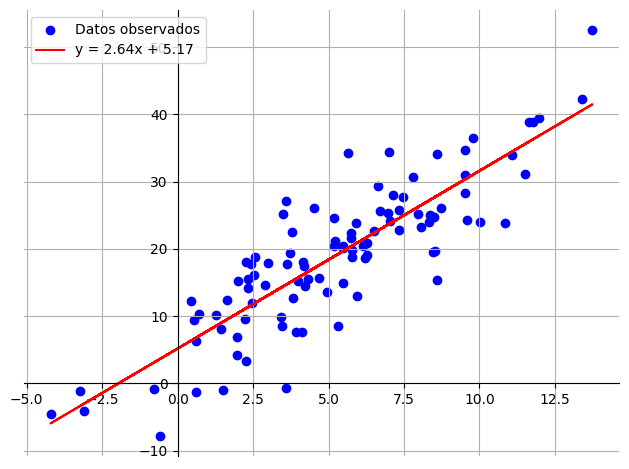

In [251]:
# Código para generar el gráfico
fig, ax = plt.subplots()
plt.scatter(data['x'], data['y'], color='blue')
plt.plot(data['x'], w_ * data['x'] + b_, color='red')
# Crear ejes X e Y
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
# Crear leyenda
plt.legend(["Datos observados", 'y = {:.2f}x + {:.2f}'.format(w_, b_)])
plt.tight_layout()
plt.show()

### 1.2. Cuesta abajo:
Ahora llega el turno al **descenso gradiente**. En general, para hacer descenso gradiente se comienza con un valor simple de los parámetros como ansatz inicial y se actualiza este progresivamente. Hagámoslo así: dale a ambos parámetros un valor nulo y actualiza con descenso gradiente durante tantos pasos como consideres necesario. Considera como <ins>learning rate 0.001</ins>. En este caso, para calcular el gradiente con el que actualizar evalúa la función de pérdida para toda la base de datos y calcula el valor de su derivada en ese punto. Para decidir cuándo parar es útil calcular la función de pérdida (MSE) en cada paso y estudiar cómo evoluciona esta a medida que actualizamos los parámetros. Puedes elegir cuándo parar según tu criterio: la función de pérdida no cambia demasiado, los parámetros se actualizan muy poquito, etc. **¿Cuántos pasos te ha llevado parar y qué criterio has elegido?** Muestra el progreso de la función de pérdida representando en el eje **X** los pasos de descenso gradiente y en el eje Y la función de pérdida en cada paso. Además, usando la misma representación que en el apartado anterior donde cada eje representa los valores de $w$ y $b$, muestra la sucesión de pasos que te llevan cada vez más cerca del óptimo. Cada paso debe ser un punto en el espacio, con coordenadas $(w, b)$. Compara todos los resultados con la solución óptima del primer apartado.

$\providecommand{\dv}[2]{\frac{d#1}{d#2}}$
**Respuesta:**
Para realizar el descenso gradiente, comenzamos con los parámetros $w = 0$ y $b = 0$ y actualizamos en cada paso usando la regla:
$$
\begin{cases}
    w = w - learning\_rate * \dv{L}{w} \\
    b = b - learning\_rate * \dv{L}{b}
\end{cases}
$$
donde $\dv{L}{w}$ y $\dv{L}{b}$ son las derivadas de la función de pérdida respecto a $w$ y $b$, respectivamente.

Calculamos la función de pérdida MSE en cada paso para ver cómo evoluciona a medida que actualizamos los parámetros. Elegimos parar cuando la función de pérdida se estabiliza y deja de disminuir significativamente.

In [252]:
def predict(X, w, b):
    """
    Calcula las predicciones para la regresión lineal.

    Argumentos:
    X -- matriz de características (np.array) de dimensiones (N, M) donde N es el número de muestras y M es el número de características
    w -- vector de pesos (np.array) de dimensiones (M,)
    b -- término de sesgo (float)

    Retorna:
    y_pred -- vector de predicciones (np.array) de dimensiones (N,)
    """

    y_pred = np.dot(X, w) + b

    return y_pred


def loss_function(y, y_pred):
    """
    Calcula la pérdida MSE (Mean Squared Error) para la regresión lineal.

    Argumentos:
    y -- vector de etiquetas (np.array) de dimensiones (N,)
    y_pred -- vector de predicciones (np.array) de dimensiones (N,)

    Retorna:
    loss -- la pérdida MSE (float)
    """

    loss = np.mean((y - y_pred) ** 2) / 2

    return loss


def gradient(X, y, y_pred):
    """
    Calcula los gradientes para la regresión lineal.

    Argumentos:
    X -- matriz de características (np.array) de dimensiones (N, M) donde N es el número de muestras y M es el número de características
    y -- vector de etiquetas (np.array) de dimensiones (N,)
    y_pred -- vector de predicciones (np.array) de dimensiones (N,)

    Retorna:
    dw -- vector gradiente de los pesos (np.array) de dimensiones (M,)
    db -- gradiente del término de sesgo (float)
    """
    if hasattr(y, "__len__"):
        N = len(y)
    else:
        N = 1
    dw = -np.dot(X.T, y - y_pred) / N
    db = -np.mean(y - y_pred)

    return dw, db


def gradient_descent(X, y, learning_rate=0.01, tolerance=0.0001, max_iterations=1000):
    """
    Aplica el algoritmo de descenso de gradiente para minimizar la función de pérdida MSE (Mean Squared Error)
    para la regresión lineal.

    Argumentos:
    X -- matriz de características (np.array) de dimensiones (N, M) donde N es el número de muestras y M es el número de características
    y -- vector de etiquetas (np.array) de dimensiones (N,)
    learning_rate -- tasa de aprendizaje (float). Por defecto: 0.01
    tolerance -- tolerancia para la convergencia (float). Por defecto: 0.0001
    max_iterations -- número máximo de iteraciones (int o None). Por defecto: 1000

    Retorna:
    w -- vector de pesos (np.array) de dimensiones (M,)
    b -- término de sesgo (float)
    losses -- vector de pérdidas (np.array) de dimensiones (n_iterations,)
    weights -- vector de pesos (np.array) de dimensiones (n_iterations,)
    biases -- vector de sesgos (np.array) de dimensiones (n_iterations,)
    """

    # Si X es un vector unidimensional, conviértelo en una matriz de una columna
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    N, M = X.shape

    # Inicializar los pesos y el término de sesgo a cero
    w = np.zeros(M)
    b = 0

    # Inicializar la pérdida previa a un valor grande
    prev_loss = float('inf')

    # Inicializar los vectores de pérdidas, pesos y sesgos
    losses = []
    weights = []
    biases = []

    # Aplicar el algoritmo de descenso de gradiente
    i = 0
    while True:
        # Calcular las predicciones y la pérdida
        y_pred = predict(X, w, b)
        loss = loss_function(y, y_pred)
        losses.append(loss)

        # Calcular los gradientes
        dw, db = gradient(X, y, y_pred)

        # Actualizar los pesos y el término de sesgo
        w -= learning_rate * dw
        b -= learning_rate * db
        weights.append([*w])
        biases.append(b)

        # Verificar la convergencia
        if abs(loss - prev_loss) < tolerance:
            break
        prev_loss = loss

        # Verificar si se ha superado el número máximo de iteraciones
        i += 1
        if max_iterations is not None and i >= max_iterations:
            break

    return w, b, np.array(losses), np.array(weights), np.array(biases)


# Convertimos datos de entrada
X = data['x'].to_numpy()
y = data['y'].to_numpy()

# Calculamos valores con una tolerancia de 1e-10
wgd, bgd, losses, weights, biases = gradient_descent(X, y, learning_rate=0.001, tolerance=1e-10, max_iterations=30000)
num_iterations = len(losses)
print("Número de pasos:", num_iterations)
print("w final:", wgd)
print("b final:", bgd)

Número de pasos: 27422
w final: [2.64327501]
b final: 5.165360265912254


En este código, consideramos que la función de pérdida se estabiliza, cuando la **diferencia de pérdidas entre iteraciones es inferior a $10^{-10}$** (a este valor se le denomina **tolerancia**). Con este valor, el número de pasos llevados es **27.422** y el **error absoluto** obtenido con respecto a la solución obtenida es de:

In [253]:
abs(w - wgd), abs(b - bgd)

(array([Abs(w - 2.64327501381065)], dtype=object), Abs(b - 5.16536026591225))

El progreso de la función de pérdida queda representado en la siguiente gráfica:

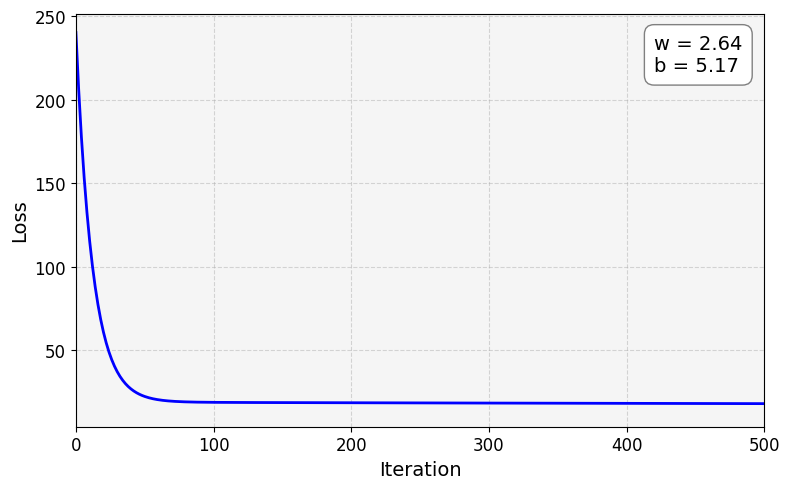

In [254]:
# Código para generar el gráfico
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(losses, linewidth=2, color='blue')
# Configurar los ejes y las etiquetas
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlim(0, 500)
# Configurar la rejilla y el fondo
ax.grid(True, alpha=0.5, linestyle='--')
ax.set_facecolor('#F5F5F5')
# Agregar texto w y b
text = f'w = {wgd[0]:.2f}\nb = {bgd:.2f}'
ax.text(0.84, 0.95, text, transform=ax.transAxes, fontsize=14, va='top', ha='left',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
# Mostrar la gráfica
plt.tight_layout()
plt.show()

Graficamos también la evolución de los pesos y sesgos.

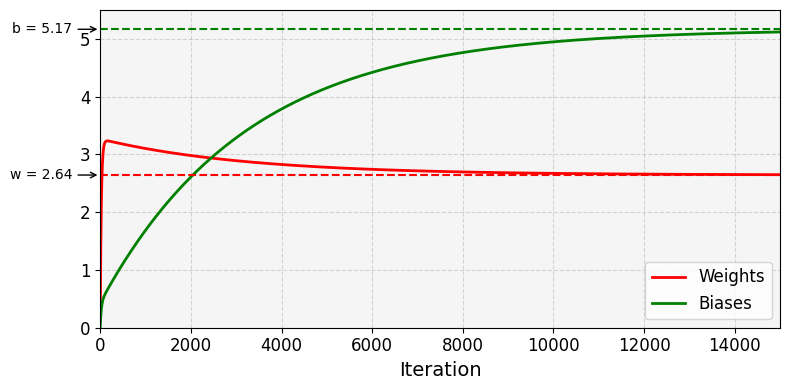

In [255]:
# Código para generar el gráfico
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(weights, linewidth=2, color='red')
plt.plot(biases, linewidth=2, color='green')
plt.axhline(w_, color='red', linestyle='--')
plt.axhline(b_, color='green', linestyle='--')
# Configurar los ejes y las etiquetas
ax.set_xlabel('Iteration', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlim(0, 15000)
ax.set_ylim(0, 5.5)
# Configurar la rejilla y el fondo
ax.grid(True, alpha=0.5, linestyle='--')
ax.set_facecolor('#F5F5F5')
# Crear leyenda
ax.legend(['Weights', 'Biases'], fontsize=12, loc='lower right')
# Anotar los valores reales de w y b
ax.annotate(f'w = {w_:.2f}', xy=(1, w_), xytext=(-20, 0),
            textcoords='offset points', va='center', ha='right',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

ax.annotate(f'b = {b_:.2f}', xy=(1, b_), xytext=(-20, 0),
            textcoords='offset points', va='center', ha='right',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
# Mostrar la gráfica
plt.tight_layout()
plt.show()

Como usamos una **tolerancia muy baja**, los $b$ y $w$ optimizados en los apartados 1.1 y 1.2 tienen valores my próximos. Flexibilizando el criterio de parada podemos notar que la diferencia entre los resultados sería mayor. El objetivo es buscar **un equilibrio entre precisión y complejidad computacional**. El algoritmo de descenso de gradiente utilizado es el más básico pero existen otros optimizadores que pueden converger más rápido p.ej. **Adam** (modificando la tasa de aprendizaje) o **SGD** (utilizando subconjuntos aleastorios).

### 1.3. El camino del borracho:
Empleando el código anterior, ahora construye tu propio código para hacer **mini-batch gradient descent** y **stochastic gradient descent**. Para cada uno de ellos necesitaras solamente hacer que la evaluación de la función objetivo se realice en un subconjunto aleatorio de los datos (mini-batch GD) o solamente en uno de los datos (stochastic GD). Como minibatch usa 5 puntos. Representa, para cada uno de estos casos, la evolución de la función de pérdida en función de los pasos dados. Muestra a la vez esta evolución para el GD original y para estos dos y comenta lo que observas. Además, en la figura del espacio de parámetros, muestra también el camino seguido por estos dos otros modelos y comenta lo que observas. Compara todos los resultados con la solución óptima del primer apartado.

**Extra**: Estudia el efecto del tamaño del minibatch en la convergencia del modelo.

El **batch size** es el número de muestras de entrenamiento que se utilizan para calcular el gradiente y actualizar los pesos del modelo en cada iteración del algoritmo de descenso de gradiente. En el **mini-batch gradient descent**, el batch size es un **hiperparámetro** que determina el número de muestras que se utilizan para estimar el gradiente de la función de pérdida en cada iteración. En **stochastic gradient descent** en cambio, el número de muestras es uno.

Definimos las funciones `mini_batch_gradient_descent` y `stochastic_gradient_descent`.

In [256]:
def mini_batch_gradient_descent(X, y, learning_rate=0.01, tolerance=0.0001, max_iterations=1000, batch_size=5, seed=42):
    """
    Aplica el algoritmo de mini-batch gradient descent para minimizar la función de pérdida MSE (Mean Squared Error) 
    para la regresión lineal. 
    
    Argumentos:
    X -- matriz de características (np.array) de dimensiones (N, M) donde N es el número de muestras y M es el número de características
    y -- vector de etiquetas (np.array) de dimensiones (N,)
    learning_rate -- tasa de aprendizaje (float). Por defecto: 0.01
    tolerance -- tolerancia para la convergencia (float). Por defecto: 0.0001
    max_iterations -- número máximo de iteraciones (int o None). Por defecto: 1000
    batch_size -- tamaño del mini-batch (int). Por defecto: 5
    seed -- semilla aleatoria (int). Por defecto: 42
    
    Retorna:
    w -- vector de pesos (np.array) de dimensiones (M,)
    b -- término de sesgo (float)
    losses -- vector de pérdidas (np.array) de dimensiones (n_iterations,)
    """
    
    # Si X es un vector unidimensional, conviértelo en una matriz de una columna
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)   
    N, M = X.shape

    # Fijamos semilla para reproducibilidad
    np.random.seed(seed)
    
    # Inicializar los pesos y el término de sesgo a cero
    w = np.zeros(M)
    b = 0
    
    # Inicializar la pérdida previa a un valor grande
    prev_loss = float('inf')
    
    # Inicializar los vectores de pérdidas, pesos y sesgos
    losses = []
    weights = []
    biases = []
    
    # Aplicar el algoritmo de mini-batch gradient descent
    i = 0
    while True:
        # Seleccionar un subconjunto aleatorio de los datos (mini-batch)
        batch_indices = np.random.choice(N, batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        # Calcular las predicciones y la pérdida
        y_pred = predict(X_batch, w, b)
        loss = loss_function(y_batch, y_pred)
        losses.append(loss)

        # Calcular los gradientes
        dw, db = gradient(X_batch, y_batch, y_pred)
        # Actualizar los pesos y el término de sesgo
        w -= learning_rate * dw
        b -= learning_rate * db
        weights.append([*w])
        biases.append(b)

        # Verificar la convergencia
        if abs(loss - prev_loss) < tolerance:
            break
        prev_loss = loss

        # Verificar si se ha superado el número máximo de iteraciones
        i += 1
        if max_iterations is not None and i >= max_iterations:
            break
        
    return w, b, np.array(losses), np.array(weights), np.array(biases)


def stochastic_gradient_descent(X, y, learning_rate=0.01, tolerance=0.0001, max_iterations=1000, seed=42):
    """
    Aplica el algoritmo de stochastic gradient descent para minimizar la función de pérdida MSE (Mean Squared Error) 
    para la regresión lineal.

    Argumentos:
    X -- matriz de características (np.array) de dimensiones (N, M) donde N es el número de muestras y M es el número de características
    y -- vector de etiquetas (np.array) de dimensiones (N,)
    learning_rate -- tasa de aprendizaje (float). Por defecto: 0.01
    tolerance -- tolerancia para la convergencia (float). Por defecto: 0.0001
    max_iterations -- número máximo de iteraciones (int o None). Por defecto: 1000
    seed -- semilla aleatoria (int). Por defecto: 42

    Retorna:
    w -- vector de pesos (np.array) de dimensiones (M,)
    b -- término de sesgo (float)
    losses -- vector de pérdidas (np.array) de dimensiones (n_iterations,)
    """

    # Si X es un vector unidimensional, conviértelo en una matriz de una columna
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)   
    N, M = X.shape

    # Fijamos semilla para reproducibilidad
    np.random.seed(seed)

    # Inicializar los pesos y el término de sesgo a cero
    w = np.zeros(M)
    b = 0

    # Inicializar la pérdida previa a un valor grande
    prev_loss = float('inf')

    # Inicializar los vectores de pérdidas, pesos y sesgos
    losses = []
    weights = []
    biases = []

    # Aplicar el algoritmo de stochastic gradient descent
    i = 0
    while True:
        # Seleccionar un dato aleatorio
        j = np.random.randint(N)
        x_j = X[j]
        y_j = y[j]
        
        # Calcular las predicciones y la pérdida
        y_pred = predict(x_j, w, b)
        loss = loss_function(y_j, y_pred)
        losses.append(loss)

        # Calcular los gradientes
        dw, db = gradient(x_j, y_j, y_pred)
        # Actualizar los pesos y el término de sesgo
        w -= learning_rate * dw
        b -= learning_rate * db
        weights.append([*w])
        biases.append(b)

        # Verificar la convergencia
        if abs(loss - prev_loss) < tolerance:
            break
        prev_loss = loss

        # Verificar si se ha superado el número máximo de iteraciones
        i += 1
        if max_iterations is not None and i >= max_iterations:
            break
        
    return w, b, np.array(losses), np.array(weights), np.array(biases)
    

Ahora veamos los resultados de cada algoritmo con el mismo conjunto de datos utilizado previamente:

In [257]:
# Aplicar el algoritmo de gradient descent
w_gd, b_gd, losses_gd, weights_gd, biases_gd = gradient_descent(X, y, learning_rate=0.001, tolerance=1e-10, max_iterations=30000)
print('Gradient Descent:')
print('\tOptimal weights:', w_gd, b_gd)
print('\tIterations:', len(losses_gd))

# Aplicar el algoritmo de mini-batch gradient descent
w_mbgd, b_mbgd, losses_mbgd, weights_mbgd, biases_mbgd = mini_batch_gradient_descent(X, y, learning_rate=0.001, tolerance=1e-10, max_iterations=30000,
                                                                                     batch_size=5)
print('Mini-batch Gradient Descent:')
print('\tOptimal weights:', w_mbgd, b_mbgd)
print('\tIterations:', len(losses_mbgd))

# Aplicar el algoritmo de stochastic gradient descent
w_sgd, b_sgd, losses_sgd, weights_sgd, biases_sgd = stochastic_gradient_descent(X, y, learning_rate=0.001, tolerance=1e-10, max_iterations=30000)
print('Stochastic Gradient Descent:')
print('\tOptimal weights:', w_sgd, b_sgd)
print('\tIterations:', len(losses_sgd))

Gradient Descent:
	Optimal weights: [2.64327501] 5.165360265912254
	Iterations: 27422
Mini-batch Gradient Descent:
	Optimal weights: [2.68364601] 5.153886782624087
	Iterations: 30000
Stochastic Gradient Descent:
	Optimal weights: [2.62356865] 5.062526441021655
	Iterations: 30000


Fijándonos en los resultados obtenidos, el algoritmo más preciso (aproxima mejor los resultados analíticos `w_` y `b_`) es el `gradient_descent` con un error prácticamente nulo. También es el algoritmo que parece converger más rápido con la tolerancia especificada. El algoritmo menos preciso encambio es el `stochastic_gradient_descent`.

In [258]:
w_, b_

(2.643140700476755, 5.166377675805432)

Para entender cómo funcionan estos algoritmos a diferencia del descenso de gradiente básico podemos verlo de la siguiente forma: Imaginemos tener un **cuenco**. Este cuenco sería la función a optimizar, o nuestra función de coste MSE en nuestro caso. En el cuenco tiraremos **una gota** y **una pelota**. La gota será la función `gradient descent`, que lentamente encontrará su camino hasta el fondo del cuenco, de forma **precisa**. La pelota en cambio (`mini_batch_gradient_descent` o `stochastic_gradient_descent`) llegará al fondo **más rápido**, aunque de forma **más rocambolesca**, rebotando con las paredes del cuenco.

<p align="center">
    <!-- Ejemplo de modelo SVM en un espacio bidimensional -->
    <img src="images/image0.png">
</p>

$\providecommand{\dv}[2]{\frac{d#1}{d#2}}$
Probablemente os preguntareis por qué entonces el descenso de gradiente toma un menor número de iteraciones que los otros dos algoritmos, Esto se debe a la **tolerancia** que estamos usando. El algoritmo espera a que **"la pelota" deje de rebotar tanto**, y se estabilice. Mientras tanto, **"la gota"**, aunque sea más lenta, una vez llega al fondo, **se estabiliza de forma casi inmediata**. Además, la efectividad de stochastic gradient (al igual que Mini-batch GD, veremos más tarde cuál es su conexión) es más visible en conjuntos de datos mucho más grandes.

De la misma forma que en el anterior apartado podemos grafica la evolución de la pérdida, pesos y sesgos para cada algoritmo.

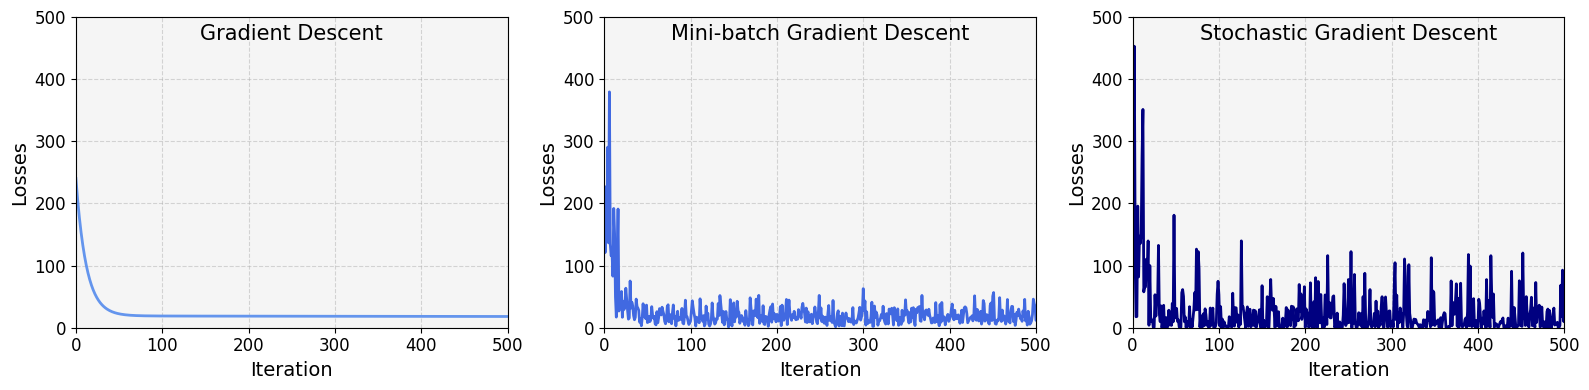

In [259]:
# Código para generar el gráfico
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(losses_gd, linewidth=2, color='cornflowerblue')
ax[1].plot(losses_mbgd, linewidth=2, color='royalblue')
ax[2].plot(losses_sgd, linewidth=2, color='navy')
algorithms = ["Gradient Descent", "Mini-batch Gradient Descent", "Stochastic Gradient Descent"]
for text, axis in zip(algorithms, ax):
    # Configurar los ejes y las etiquetas
    axis.set_xlabel('Iteration', fontsize=14)
    axis.set_ylabel('Losses', fontsize=14)
    axis.tick_params(axis='both', labelsize=12)
    axis.set_xlim(0, 500)
    axis.set_ylim(0, 500)
    # Configurar la rejilla y el fondo
    axis.grid(True, alpha=0.5, linestyle='--')
    axis.set_facecolor('#F5F5F5')
    axis.set_title(text, y=0.9, fontsize=15)
# Mostrar la gráfica
plt.tight_layout()
plt.show()

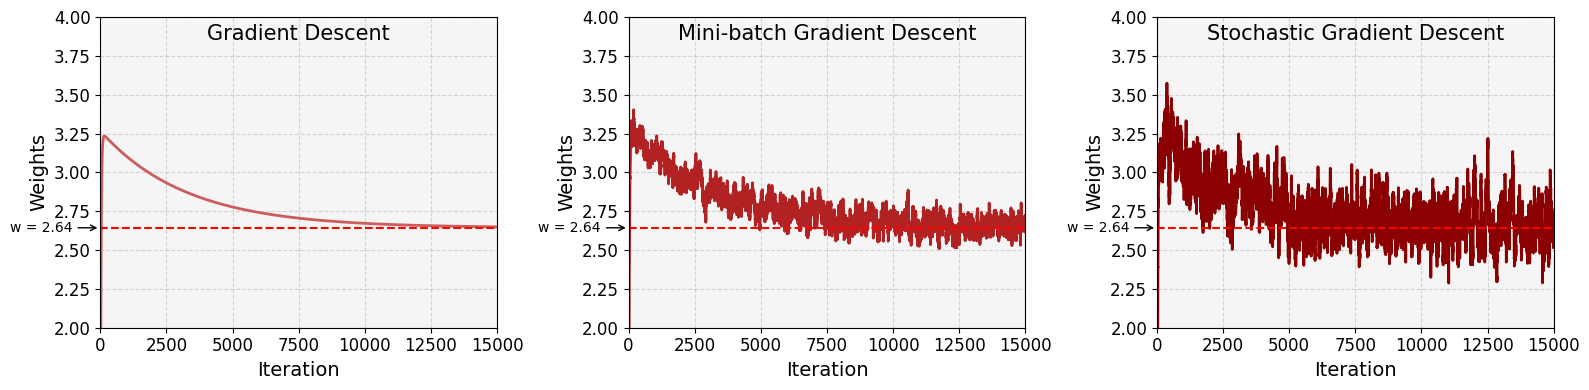

In [260]:
# Código para generar el gráfico
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(weights_gd, linewidth=2, color='indianred')
ax[1].plot(weights_mbgd, linewidth=2, color='firebrick')
ax[2].plot(weights_sgd, linewidth=2, color='darkred')
algorithms = ["Gradient Descent", "Mini-batch Gradient Descent", "Stochastic Gradient Descent"]
for text, axis in zip(algorithms, ax):
    axis.axhline(w_, color='red', linestyle='--')
    # Configurar los ejes y las etiquetas
    axis.set_xlabel('Iteration', fontsize=14)
    axis.set_ylabel('Weights', fontsize=14)
    axis.tick_params(axis='both', labelsize=12)
    axis.set_xlim(0, 15000)
    axis.set_ylim(2, 4)
    # Configurar la rejilla y el fondo
    axis.grid(True, alpha=0.5, linestyle='--')
    axis.set_facecolor('#F5F5F5')
    # Anotar los valores reales de w
    axis.annotate(f'w = {w_:.2f}', xy=(1, w_), xytext=(-20, 0),
                textcoords='offset points', va='center', ha='right',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
    axis.set_title(text, y=0.9, fontsize=15)
# Mostrar la gráfica
plt.tight_layout()
plt.show()

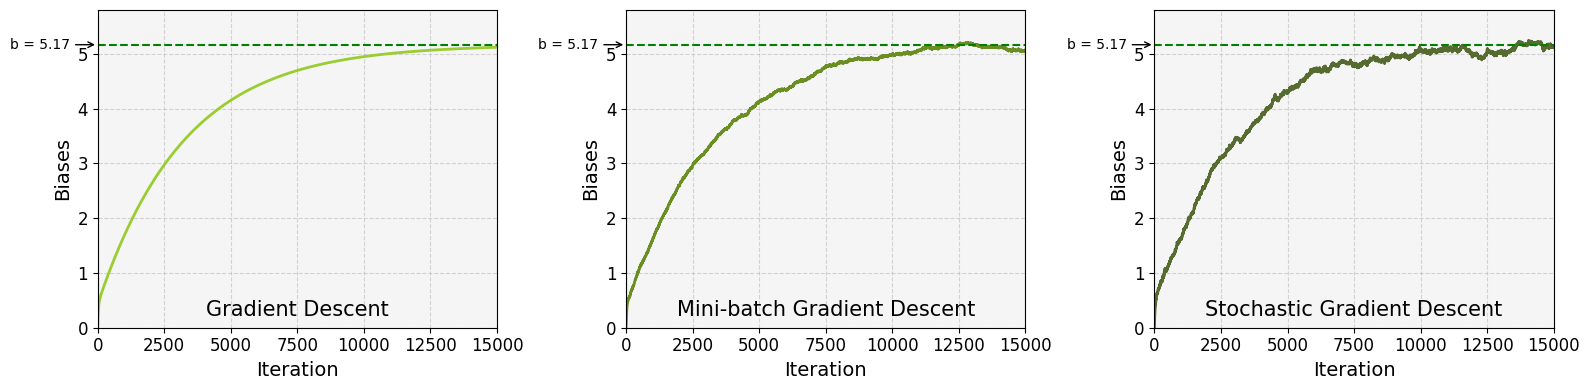

In [261]:
# Código para generar el gráfico
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(biases_gd, linewidth=2, color='yellowgreen')
ax[1].plot(biases_mbgd, linewidth=2, color='olivedrab')
ax[2].plot(biases_sgd, linewidth=2, color='darkolivegreen')
algorithms = ["Gradient Descent", "Mini-batch Gradient Descent", "Stochastic Gradient Descent"]
for text, axis in zip(algorithms, ax):
    axis.axhline(b_, color='green', linestyle='--')
    # Configurar los ejes y las etiquetas
    axis.set_xlabel('Iteration', fontsize=14)
    axis.set_ylabel('Biases', fontsize=14)
    axis.tick_params(axis='both', labelsize=12)
    axis.set_xlim(0, 15000)
    axis.set_ylim(0, 5.8)
    # Configurar la rejilla y el fondo
    axis.grid(True, alpha=0.5, linestyle='--')
    axis.set_facecolor('#F5F5F5')
    # Anotar los valores reales de b
    axis.annotate(f'b = {b_:.2f}', xy=(1, b_), xytext=(-20, 0),
                textcoords='offset points', va='center', ha='right',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
    axis.set_title(text, y=0.01, fontsize=15)
# Mostrar la gráfica
plt.tight_layout()
plt.show()

Volviendo al ejemplo de la gota, vemos como las curvas de evolución de `gradient_descent` son suaves, mientras que las de los otros dos algoritmos son complejas, incluso **"ruidosas"**. Es importante notar como el ruido aumenta pronunciadamente de Mini-batch gradient descent al Stochastic Gradient Descent. Esto se debe a que **a medida que el subconjunto aleatorio seleccionado es menor, el ruido aumenta**.

El **batch size** tiene un efecto significativo en el rendimiento y la velocidad del entrenamiento del modelo. Un batch size pequeño, como 1 o 32, puede resultar en actualizaciones de pesos más frecuentes y una convergencia más rápida del modelo. Además, puede ayudar a evitar mínimos locales subóptimos, ya que el gradiente se calcula a partir de **una muestra más variada de datos**. Sin embargo, un batch size pequeño también puede llevar a una convergencia inestable y **ruidosa** debido a que el gradiente calculado es **una estimación menos precisa del gradiente real de la función de pérdida**.

Por otro lado, un **batch size grande**, como 512 o 1024, puede mejorar la precisión de la estimación del gradiente y **suavizar el proceso de convergencia**, ya que el gradiente se calcula a partir de una muestra más grande de datos. Sin embargo, un batch size grande también puede ser menos eficiente en términos de tiempo de entrenamiento debido a la **mayor cantidad de cálculos necesarios** para calcular el gradiente y actualizar los pesos.

Para entender mejor los **batch sizes** podemos graficar los pesos y sesgos de diferentes tamaños de muestra.

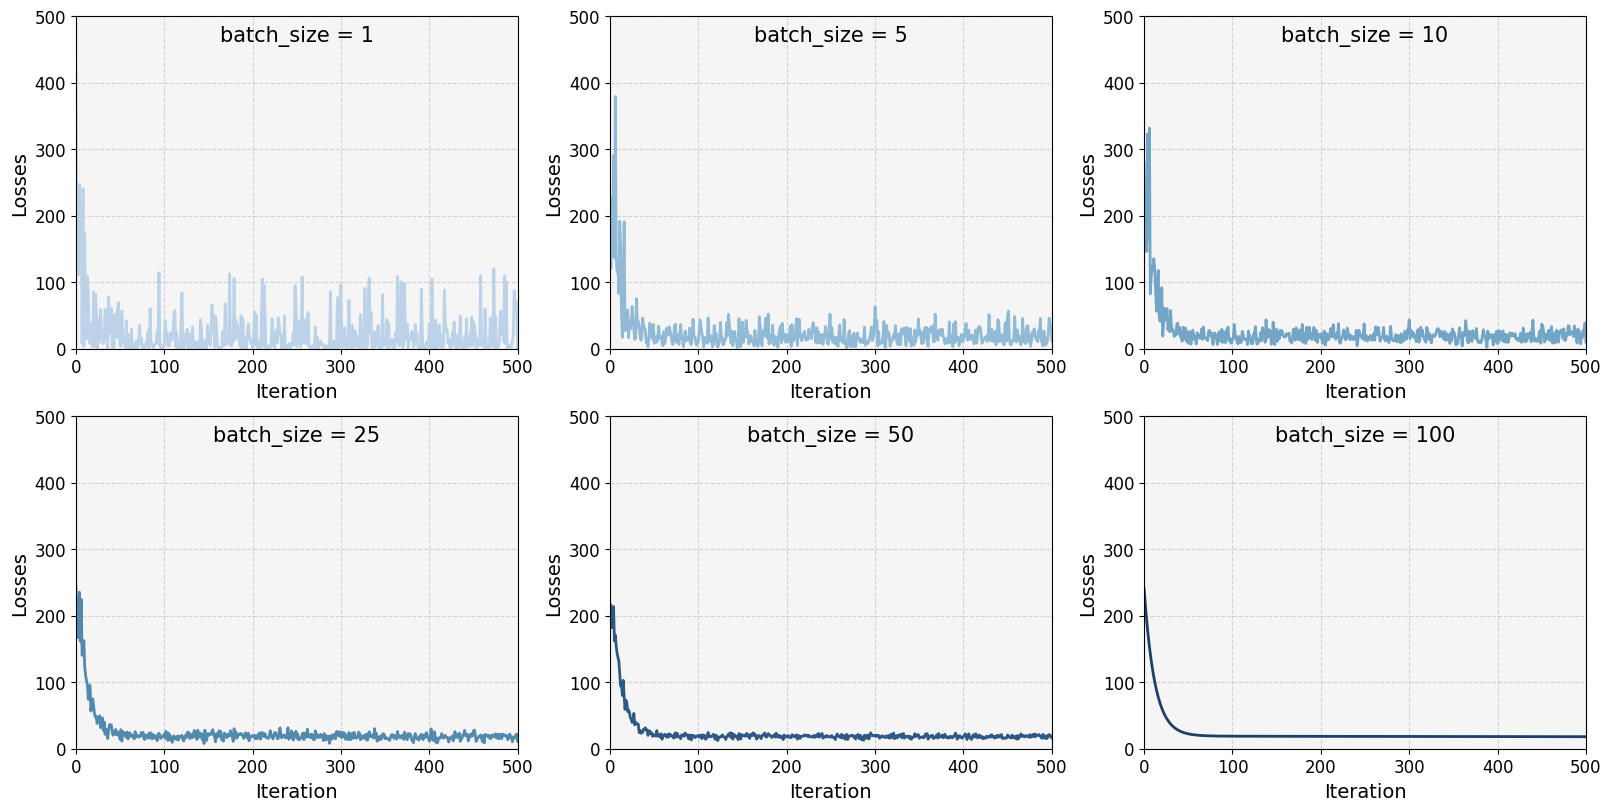

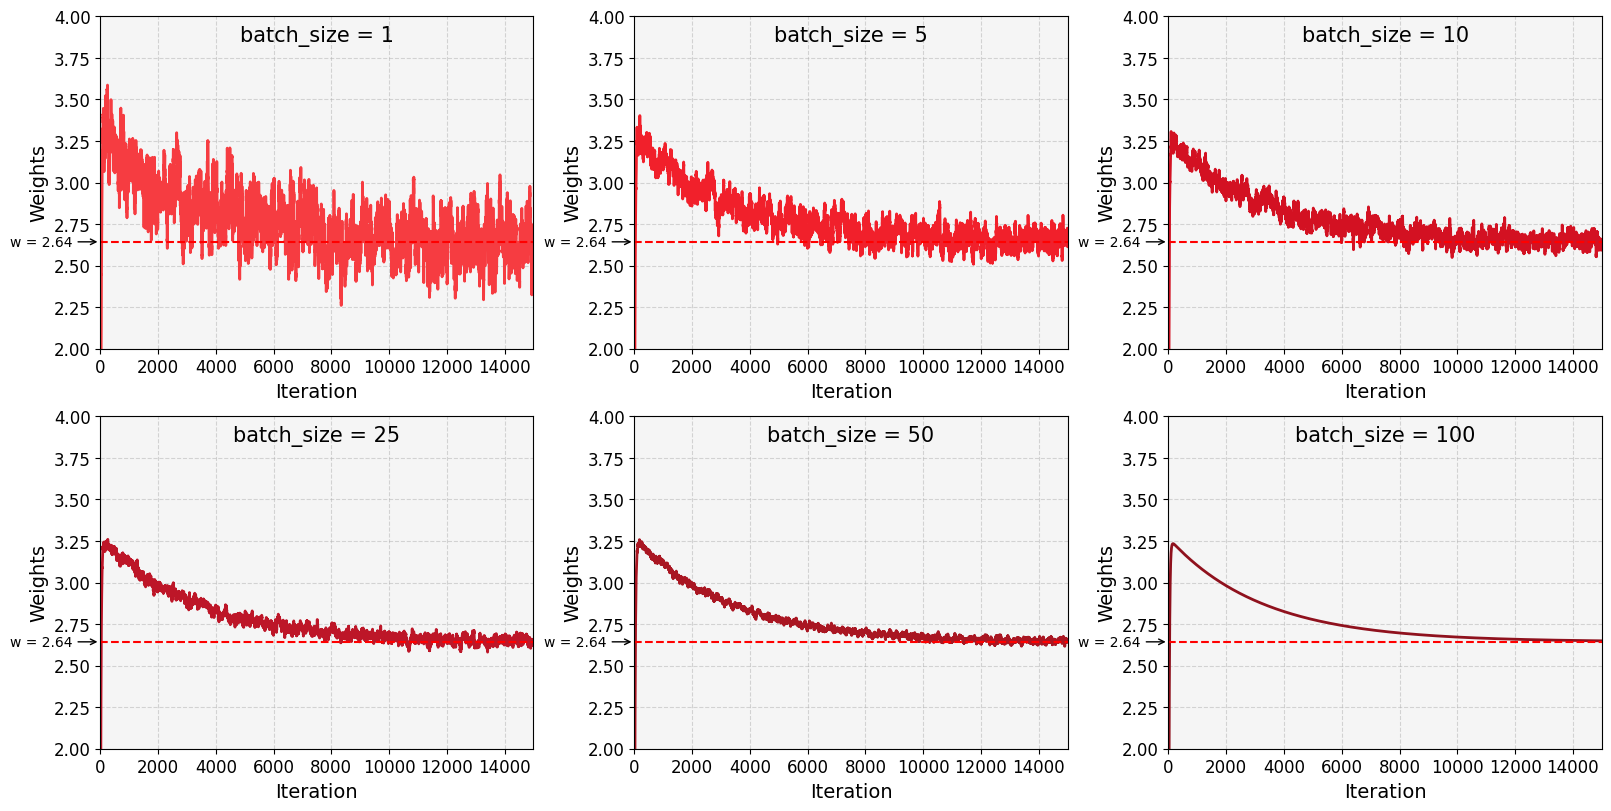

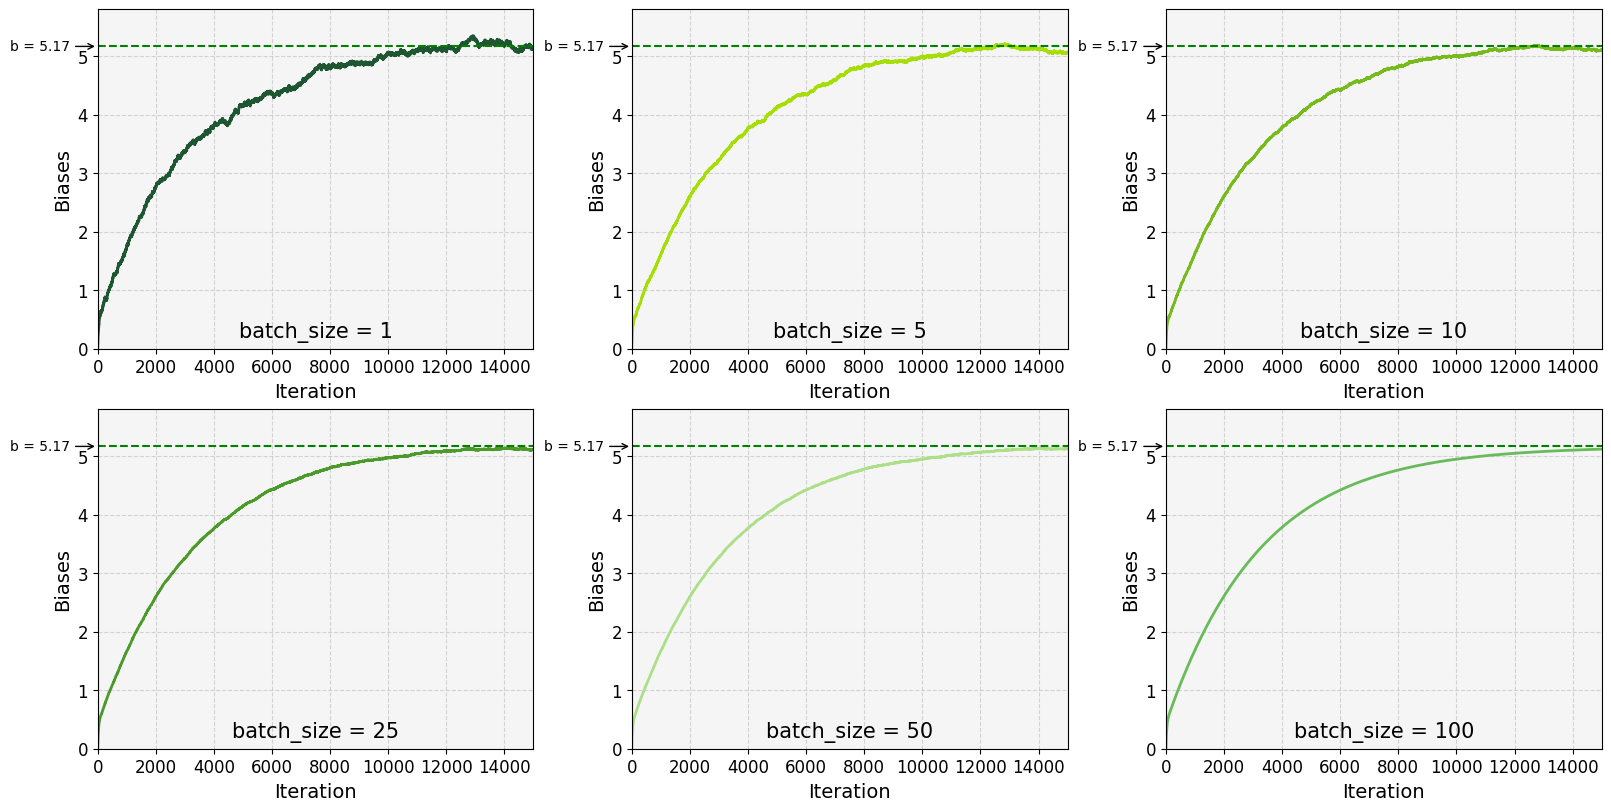

In [262]:
fig1, ax1 = plt.subplots(2, 3, figsize=(16, 8), layout='constrained')
fig2, ax2 = plt.subplots(2, 3, figsize=(16, 8), layout='constrained')
fig3, ax3 = plt.subplots(2, 3, figsize=(16, 8), layout='constrained')
batch_sizes = [1, 5, 10, 25, 50, 100]
loss_colors = ['#BCD2E8', '#91BAD6', '#73A5C6', '#528AAE', '#2E5984', '#1E3F66']
weight_colors = ['#F63C41', '#F1202B', '#D31122', '#BD1628', '#A91622', '#8F111D']
bias_colors = ['#1E5631', '#A4DE02', '#76BA1B', '#4C9A2A', '#ACDF87', '#68BB59']

for i, (axl, axw, axb) in enumerate(zip(ax1.flatten(), ax2.flatten(), ax3.flatten())):
    wmbgd, bmbgd, losses, weights, biases = mini_batch_gradient_descent(X, y, learning_rate=0.001, tolerance=1e-10, max_iterations=30000,
                                                                        batch_size=batch_sizes[i])
    # Gráfica de pérdidas #
    axl.plot(losses, linewidth=2, color=loss_colors[i])
    # Configurar los ejes y las etiquetas
    axl.set_xlabel('Iteration', fontsize=14)
    axl.set_ylabel('Losses', fontsize=14)
    axl.tick_params(axis='both', labelsize=12)
    axl.set_xlim(0, 500)
    axl.set_ylim(0, 500)
    # Configurar la rejilla y el fondo
    axl.grid(True, alpha=0.5, linestyle='--')
    axl.set_facecolor('#F5F5F5')
    axl.set_title(f"batch_size = {batch_sizes[i]}", y=0.9, fontsize=15)

    # Gráfica de pesos #
    axw.plot(weights, linewidth=2, color=weight_colors[i])
    axw.axhline(w_, color='red', linestyle='--')
    # Configurar los ejes y las etiquetas
    axw.set_xlabel('Iteration', fontsize=14)
    axw.set_ylabel('Weights', fontsize=14)
    axw.tick_params(axis='both', labelsize=12)
    axw.set_xlim(0, 15000)
    axw.set_ylim(2, 4)
    # Configurar la rejilla y el fondo
    axw.grid(True, alpha=0.5, linestyle='--')
    axw.set_facecolor('#F5F5F5')
    # Anotar los valores reales de w
    axw.annotate(f'w = {w_:.2f}', xy=(1, w_), xytext=(-20, 0),
                textcoords='offset points', va='center', ha='right',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
    axw.set_title(f"batch_size = {batch_sizes[i]}", y=0.9, fontsize=15)

    # Gráfica de sesgos #
    axb.plot(biases, linewidth=2, color=bias_colors[i])
    axb.axhline(b_, color='green', linestyle='--')
    # Configurar los ejes y las etiquetas
    axb.set_xlabel('Iteration', fontsize=14)
    axb.set_ylabel('Biases', fontsize=14)
    axb.tick_params(axis='both', labelsize=12)
    axb.set_xlim(0, 15000)
    axb.set_ylim(0, 5.8)
    # Configurar la rejilla y el fondo
    axb.grid(True, alpha=0.5, linestyle='--')
    axb.set_facecolor('#F5F5F5')
    # Anotar los valores reales de b
    axb.annotate(f'b = {b_:.2f}', xy=(1, b_), xytext=(-20, 0),
                textcoords='offset points', va='center', ha='right',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
    axb.set_title(f"batch_size = {batch_sizes[i]}", y=0.01, fontsize=15)


En estas gráficas se puede observar el fenómeno anteriormente mencionado. Cuando el `batch_size` equivale a 1, el `mini_batch_gradient_descent` es equivalente al `stochastic_gradient_descent`, ambos seleccionando un subconjunto aleatorio de tamaño único. Del mismo modo, cuando el tamaño es 100 el subconjunto es del mismo tamaño que el conjunto de datos original por lo que el resultado es el mismo que el de `gradient_descent` (Nota: Al escoger el subconjunto, no hay reemplazamiento).

También se puede observar que **a menor `batch_size` el algoritmo parece aproximarse al resultado más rápido**, con pendientes más agudas. Este efecto encamina la idea de estos algoritmos convergen habitualmente más rápido que el descenso de gradiente clásico, pero de forma menos precisa.

En resumen, el batch size es un hiperparámetro importante que **afecta la velocidad y la precisión del entrenamiento del modelo** en el mini-batch gradient descent. Se debe encontrar un equilibrio entre un batch size pequeño para una convergencia rápida y evitar mínimos locales subóptimos, y un batch size grande para una estimación precisa del gradiente y una convergencia más suave. Además, diferentes batch sizes pueden tener diferentes efectos en diferentes conjuntos de datos y modelos, por lo que se debe realizar un ajuste cuidadoso del batch size para obtener el mejor rendimiento del modelo.

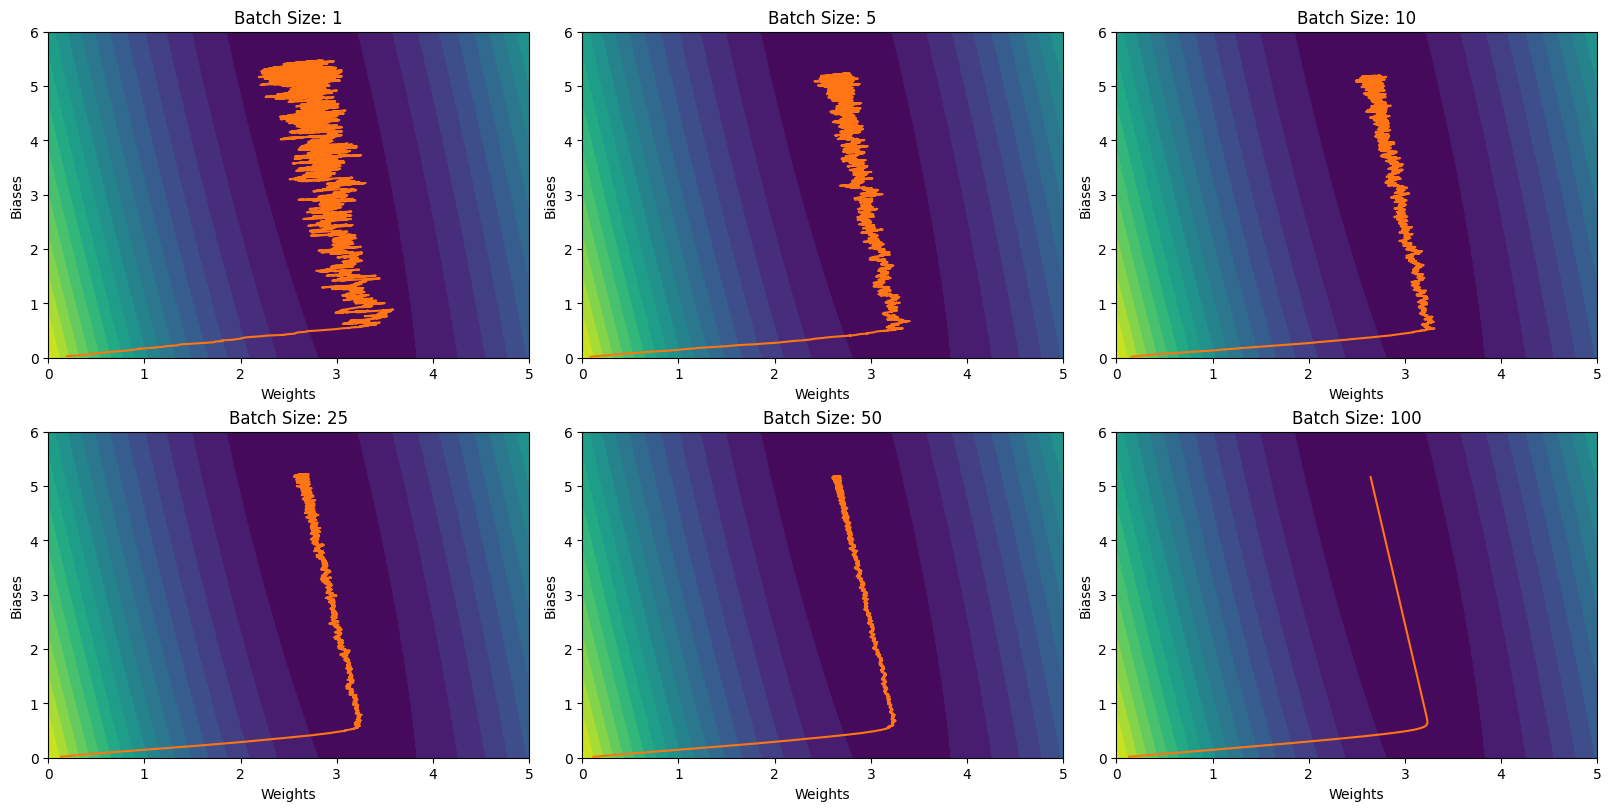

In [263]:
# Crear un meshgrid de pesos y sesgos
weight_range = np.linspace(0, 5, 100)
bias_range = np.linspace(0, 6, 100)
xx, yy = np.meshgrid(weight_range, bias_range)

# Calcular MSE para cada peso y sesgo
zz = np.zeros_like(xx)
for i in range(len(weight_range)):
    for j in range(len(weight_range)):
        y_pred = weight_range[i] * X + bias_range[j]
        zz[j, i] = np.mean((y - y_pred)**2)

# Graficar resultados para cada batch size
batch_sizes = [1, 5, 10, 25, 50, 100]
fig, axs = plt.subplots(2, 3, figsize=(16, 8), layout='constrained')

for batch_size, ax in zip(batch_sizes, axs.flatten()):
    wmbgd, bmbgd, losses, weights, biases = mini_batch_gradient_descent(X, y, learning_rate=0.001, tolerance=1e-10, max_iterations=30000,
                                                                        batch_size=batch_size)
    ax.plot(weights, biases, color='#FF7514')
    ax.contourf(xx, yy, zz, levels=20)
    ax.set_xlabel('Weights')
    ax.set_ylabel('Biases')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 6)
    ax.set_title(f'Batch Size: {batch_size}')

### 1.4. Tamaño de los pasos:
¿Qué ocurre si cambias alfa? Prueba a ejecutar los diferentes modelos de descenso gradiente para un rango variado de valores de alfa y muestra cómo evoluciona la función objetivo para cada valor de alfa. Puedes hacerlo solamente con el modelo de descenso gradiente por batches (o completo), no necesitas hacerlo con mini-batches ni la versión estocástica en este caso.

**Extra**: Si quieres, intenta también definir una forma de ir variando alfa que haga que te quedes cerca del mínimo, detallando cómo lo has hecho.

La **tasa de aprendizaje** (learning rate o $\alpha$) en el descenso de gradiente es un hiperparámetro importante que controla el tamaño de los pasos que el algoritmo toma en la dirección opuesta al gradiente para minimizar la función de pérdida.

En Machine Learning muchas veces **dar pequeños pasos en la dirección correcta** nos lleva a obtener mejores predicciones para nuevos datos. La tasa de aprendizaje es un hiperparámetro que **escala** las contribuciones llevadas a cabo en cada contribución del algoritmo. Una mayor tasa de aprendizaje implica que el tamaño de los pasos en cada iteración aumenta.

Podemos graficar cómo afecta la tasa de aprendizaje al resultado. Para visualizar mejor el resultado utilizaremos la función `stochastic_gradient_descent`. (Mejor no ejecutar la siguiente celda, puede llevar bastante tiempo. Aprox: 2min)

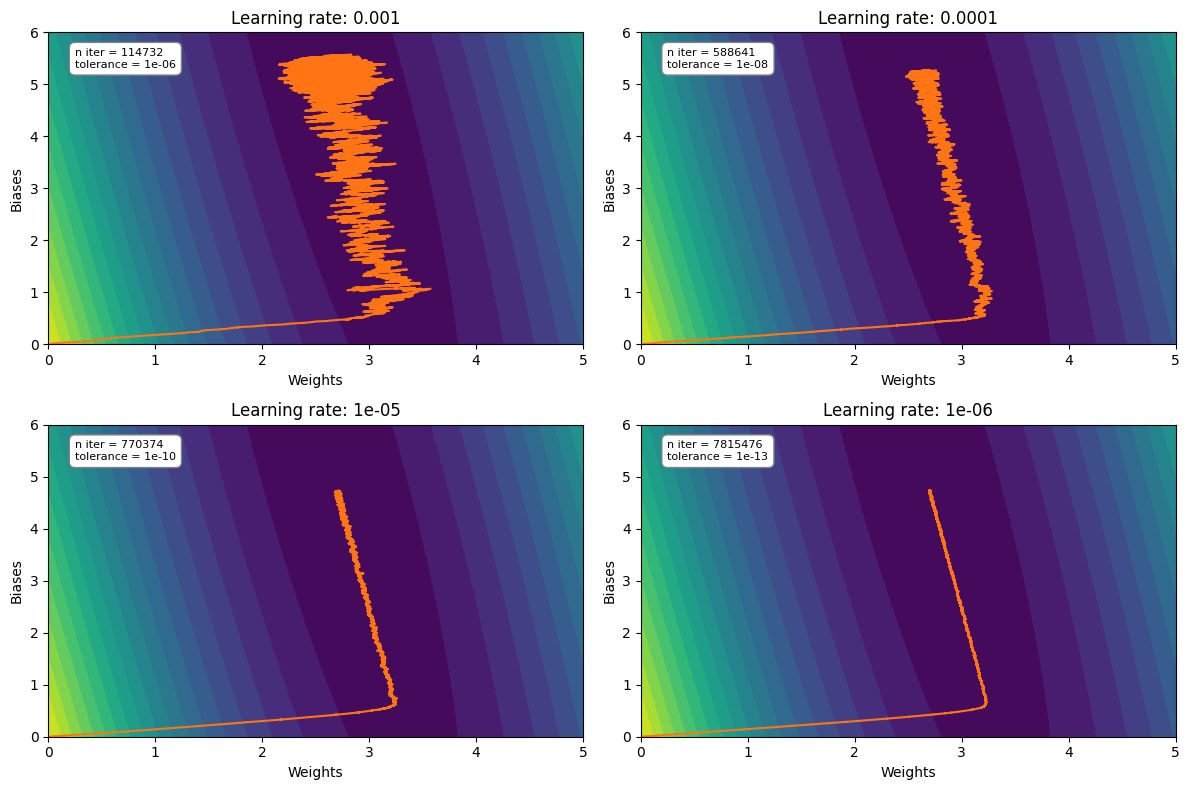

In [264]:
# Crear un meshgrid de pesos y sesgos
weight_range = np.linspace(0, 5, 100)
bias_range = np.linspace(0, 6, 100)
xx, yy = np.meshgrid(weight_range, bias_range)

# Calcular MSE para cada peso y sesgo
zz = np.zeros_like(xx)
for i in range(len(weight_range)):
    for j in range(len(weight_range)):
        y_pred = weight_range[i] * X + bias_range[j]
        zz[j, i] = np.mean((y - y_pred)**2)

# Graficar resultados para cada tasa de aprendizaje en 4 gráficos distintos
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
tolerances = [1e-6, 1e-8, 1e-10, 1e-13]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for lr, tol, ax in zip(learning_rates, tolerances, axs.flatten()):
    w, b, losses, weights, biases = stochastic_gradient_descent(X, y, learning_rate=lr, tolerance=tol, max_iterations=None)
    ax.plot(weights, biases, color='#FF7514')
    ax.contourf(xx, yy, zz, levels=20)
    ax.set_xlabel('Weights')
    ax.set_ylabel('Biases')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 6)

    text = f"n iter = {len(losses)}\ntolerance = {tol}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=8, va='top', ha='left',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
    ax.set_title(f'Learning rate: {lr}')

plt.tight_layout()
plt.show()

Si probamos con learning rates mayores, es probable que el algoritmo diverja, buscando el mínimo global de la función.

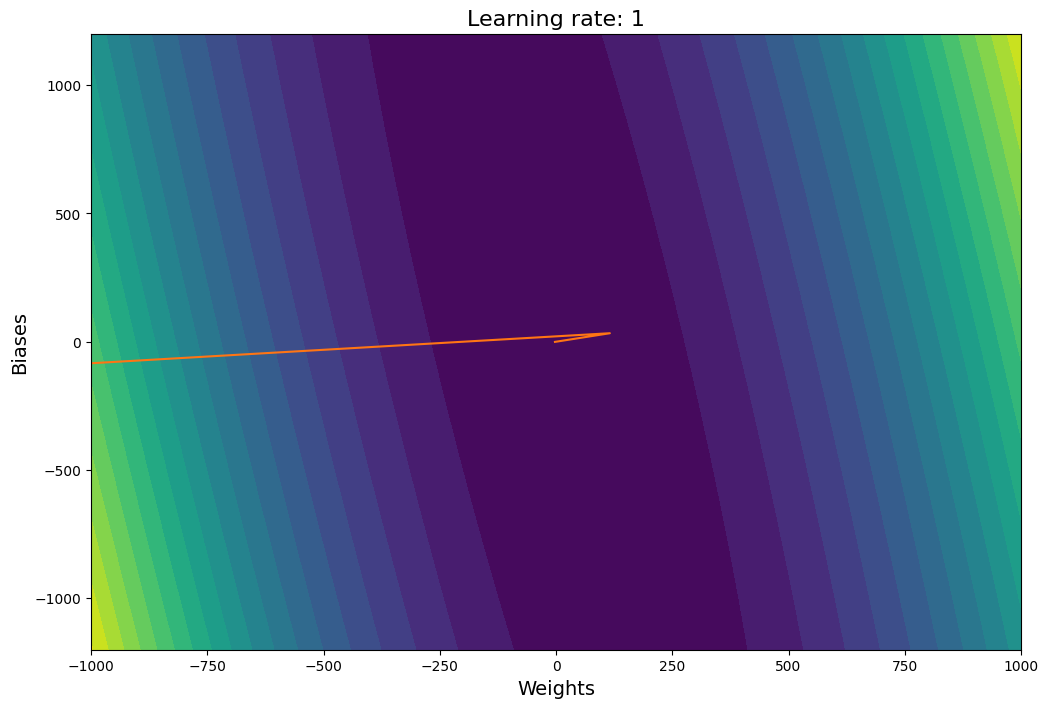

In [265]:
# Crear un meshgrid de pesos y sesgos
weight_range = np.linspace(-1000, 1000, 100)
bias_range = np.linspace(-1200, 1200, 100)
xx, yy = np.meshgrid(weight_range, bias_range)

# Calcular MSE para cada peso y sesgo
zz = np.zeros_like(xx)
for i in range(len(weight_range)):
    for j in range(len(weight_range)):
        y_pred = weight_range[i] * X + bias_range[j]
        zz[j, i] = np.mean((y - y_pred)**2)

fig, ax = plt.subplots(figsize=(12, 8))
w, b, losses, weights, biases = stochastic_gradient_descent(X, y, learning_rate=1, tolerance=1e-5, max_iterations=30)
ax.plot(weights, biases, color='#FF7514')
ax.contourf(xx, yy, zz, levels=20)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Biases', fontsize=14)
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1200, 1200)
ax.set_title(f'Learning rate: {1}', fontsize=16)
plt.show()

**¿Qué vemos exactamente en estas gráficas?**

Una **learning rate alta** <ins>acelera el proceso de convergencia del algoritmo</ins>, lo que significa que se necesitará menos tiempo para que el modelo alcance un mínimo local de la función de pérdida. Sin embargo, una learning rate alta también puede llevar a que <ins>el algoritmo oscile y nunca converja, o incluso que diverja y se aleje del mínimo local (como se observa en la última figura)</ins>.

Por otro lado, una **tasa de aprendizaje baja** permite que el algoritmo <ins>converja de manera más precisa a un mínimo local</ins>, lo que garantiza una solución más estable. Pero una tasa de aprendizaje baja también significa que <ins>el algoritmo tardará más en converger y puede quedar atrapado en un mínimo local subóptimo</ins>, especialmente si el mínimo local no es el mínimo global.

Por lo tanto, la elección de la tasa de aprendizaje adecuada es crucial para un entrenamiento exitoso del modelo con descenso de gradiente. Se deben realizar pruebas y ajustes en la tasa de aprendizaje para encontrar **el equilibrio adecuado entre una tasa alta y baja**.

Muchas veces lo óptimo es que el propio algoritmo pueda modificar el tamaño del paso, para poder equilibrar el **intercambio entre precisión y velocidad**. A continuación definiremos una función/clase más completa de `stochastic_gradient descent` (en realidad se trata de mini-batch descent, pero por su similitud muchos autores lo llaman de manera indistinta).

In [266]:
class ModelNotTrainedError(Exception):
        def __init__(self):
            self.message = "Model has not been trained yet. Please fit the model before attempting to make predictions."
            super().__init__(self.message)


class StochasticGradientRegressor:
    """
    Regressor for linear regression using stochastic gradient descent.
    

    Methods
    -------
    fit(X, y)
        Fit the linear regression model to the given data.
    predict(X)
        Predict the targets for the input data X using the trained linear classifier.
    """

    def __init__(self, cost_func='mse', regularization=None, reg_lambda=0.01, learning_rate=0.1,
                 adaptive_lr=False, decay_rate=0.9, max_epochs=1000, batch_size=32, epsilon=1e-7,
                 random_state=None, verbose=True):
        """
        Initializes the regressor with the given hyperparameters.

        Parameters:
        -----------
        cost_func : str, optional (default='mse')
            The cost function to use. Can be one of 'mse' (mean squared error), 'rmse' (root mean
            squared error), 'mae' (mean absolute error), or 'logistic' (logistic regression).
        regularization : str or None, optional (default=None)
            The regularization method to use. Can be one of 'l1', 'l2', 'elastic_net', or None.
        reg_lambda : float, optional (default=0.01)
            The regularization strength (lambda) parameter.
        learning_rate : float, optional (default=0.01)
            The learning rate for the gradient descent update.
        adaptive_lr : bool, optional (default=False)
            Whether to use adaptive learning rate.
        decay_rate : float, optional (default=0.9)
            The decay rate for the adaptive learning rate update.
        max_epochs : int, optional (default=1000)
            The maximum number of epochs (iterations) to run the gradient descent algorithm.
        batch_size : int, optional (default=32)
            The batch size for mini-batch gradient descent.
        epsilon : float, optional (default=1e-7)
            A small value used to prevent division by zero.
        random_state : int or None, optional (default=None)
            The random seed to use for shuffling the data.
        verbose : bool, optional (default=True)
            Whether to print progress messages during training.
        """

        self.cost_func = cost_func
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        self.adaptive_lr = adaptive_lr
        self.decay_rate = decay_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.random_state = random_state
        self.verbose = verbose
        self.w, self.b = None, None

        if self.adaptive_lr:
            self.lr_schedule = learning_rate

    def _calculate_cost(self, X, y, w, b):
        """
        Calculate the cost function for a given set of inputs and weights.
        """
        n_samples = X.shape[0]
        y_pred = X.dot(w) + b
        cost = None

        if self.cost_func == 'mse':
            cost = 1/(2*n_samples) * np.sum((y_pred - y)**2)
        elif self.cost_func == 'rmse':
            cost = np.sqrt(1/n_samples * np.sum((y_pred - y)**2))
        elif self.cost_func == 'mae':
            cost = 1/n_samples * np.sum(np.abs(y_pred - y))
        elif self.cost_func == 'logistic':
            cost = 1/n_samples * np.sum(np.log(1 + np.exp(-y * y_pred)))

        if self.regularization == 'l1':
            cost += self.reg_lambda * np.sum(np.abs(w))
        elif self.regularization == 'l2':
            cost += self.reg_lambda * np.sum(w**2)
        elif self.regularization == 'elastic_net':
            cost += self.reg_lambda * (1 - self.learning_rate) * np.sum(w**2) + self.reg_lambda * self.learning_rate * np.sum(np.abs(w))

        return cost

    def _calculate_gradient(self, X, y, w, b):
        """
        Calculate the gradient of the cost function for a given set of inputs, weights, and bias.
        """
        n_samples = X.shape[0]
        y_pred = X.dot(w) + b
        dJ_dw, dJ_db = None, None

        if self.cost_func == 'mse':
            dJ_dw = 1/n_samples * (X.T.dot(y_pred - y))
            dJ_db = 1/n_samples * np.sum(y_pred - y)
        elif self.cost_func == 'rmse':
            dJ_dw = 1/n_samples * (X.T.dot(y_pred - y)) / np.sqrt(np.sum((y_pred - y)**2))
            dJ_db = 1/n_samples * np.sum((y_pred - y)) / np.sqrt(np.sum((y_pred - y)**2))
        elif self.cost_func == 'mae':
            dJ_dw = 1/n_samples * (X.T.dot(np.sign(y_pred - y)))
            dJ_db = 1/n_samples * np.sum(np.sign(y_pred - y))
        elif self.cost_func == 'logistic':
            dJ_dw = 1/n_samples * (X.T.dot(y_pred - y) * y) / (1 + np.exp(y * y_pred))
            dJ_db = 1/n_samples * np.sum((y_pred - y) * y) / (1 + np.exp(y * y_pred))

        if self.regularization == 'l1':
            dJ_dw += self.reg_lambda * np.sign(w)
        elif self.regularization == 'l2':
            dJ_dw += 2 * self.reg_lambda * w
        elif self.regularization == 'elastic_net':
            dJ_dw += self.reg_lambda * ((1 - self.learning_rate) * 2 * w + self.learning_rate * np.sign(w))

        return dJ_dw, dJ_db

    def _update_learning_rate(self, epoch):
        """
        Updates the learning rate for the given epoch if adaptive learning rate is enabled.
        """
        if self.adaptive_lr:
            self.learning_rate = self.lr_schedule / (1 + self.decay_rate * epoch)

    def fit(self, X, y):
        """
        Fits the model to the given data.
        Parameters:
        -----------
        X : ndarray
            The feature matrix with shape (n_samples, n_features).
        y : ndarray
            The target variable with shape (n_samples,).

        Returns:
        --------
        w : ndarray
            The learned weight vector with shape (n_features,).
        b : float
            The learned bias term.
        costs : list
            The training cost at each epoch.

        """
        rng = np.random.RandomState(self.random_state)
        n_samples, n_features = X.shape
        w = np.zeros(n_features)
        b = 0
        costs = []

        for epoch in range(self.max_epochs):
            if self.adaptive_lr:
                self._update_learning_rate(epoch)

            # Shuffle the data
            permutation = rng.permutation(n_samples)
            X = X[permutation]
            y = y[permutation]

            for i in range(0, n_samples, self.batch_size):
                # Get the current batch
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]

                # Calculate the gradient and cost
                dJ_dw, dJ_db = self._calculate_gradient(X_batch, y_batch, w, b)
                cost = self._calculate_cost(X_batch, y_batch, w, b)

                # Update the weights and bias
                w -= self.learning_rate * dJ_dw
                b -= self.learning_rate * dJ_db

            # Calculate the cost for the entire dataset and append to the costs list
            cost = self._calculate_cost(X, y, w, b)
            costs.append(cost)

            if self.verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}: cost = {cost}")

            self.w = w
            self.b = b
        return w, b, costs

    def predict(self, X):
        """
        Predict the targets for the input data X using the trained linear regressor.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data, where n_samples is the number of samples
            and n_features is the number of features.

        Returns
        -------
        y_pred : array, shape (n_samples,)
            Predicted class labels for the input data X.

        Raises
        ------
        NotFittedError : if self.w or self.b are None
            If the linear regressor has not been fitted (i.e., trained) yet,
            attempting to predict with it will raise a NotFittedError.
        """

        if self.w is None or self.b is None:
            raise ModelNotTrainedError
        return X.dot(self.w) + self.b

Probaremos la función con un conjunto de datos sintéticos.

In [267]:
# Generar datos sintéticos
np.random.seed(42)
n_samples = 1000
X = np.random.randn(n_samples, 2)
y = 2*X[:,0] + 3*X[:,1] + np.random.randn(n_samples)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_ratio = 0.8
train_size = int(train_ratio * n_samples)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Create an instance of the StochasticGradientRegressor class
sgd = StochasticGradientRegressor(cost_func='mse', regularization=None, learning_rate=0.1,
                                  adaptive_lr=True, decay_rate=0.4, max_epochs=2000, batch_size=32, epsilon=1e-10,
                                  random_state=42, verbose=False)

# Fit the model on the training data
w, b, costs = sgd.fit(X_train, y_train)
print(f"Weights: {w}\tBias: {b}")

Weights: [2.01996607 3.00513414]	Bias: 0.006778265782175007


In [268]:
X_train_ = np.insert(X_train, 0, 1, axis=1)
XtX = np.dot(X_train_.T, X_train_)
Xty = np.dot(X_train_.T, y_train)
w_analytical = np.linalg.solve(XtX, Xty)
print(f"Analytical Weights: {w_analytical[1:]}\tAnalytical Bias: {w_analytical[0]}")

Analytical Weights: [2.01996795 3.00513439]	Analytical Bias: 0.006777783661512853


Ahora expliquemos un poco el funcionamiento de `StochasticGradientRegressor`. Esta clase es un modelo regresor que usa descenso de gradiente estocástico entrenado con un conjunto de datos etiquetados para predecir el valor de nuevos datos sin etiquetar. Principalmente, se implementan 3 funcionalidades nuevas respecto a la antigua función.

La primera es que el usuario puede **elegir qué función de coste optimizará el modelo**. Las funciones de pérdida escogidas son:
- **MSE**: $\frac{1}{2n}\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^{2}$
- **RMSE**: $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\hat{y}_{i} - y_{i})^{2}}$
- **MAE**: $\frac{1}{n}\sum_{i=1}^{n}|y_{i}-\hat{y}_{i}|$
- **Logística**: $\frac{1}{n}\sum_{i=1}^{n}\ln(1 + e^{-y_{i}\hat{y}_{i}})$
El gradiente se obtiene de calculando la derivada de estas funciones.

**Nota**: Existen muchas más funciones de pérdida v.g. **pérdida Huber**, usada en *robust regression*, cuya implementación es más compleja y no es el objetivo de esta práctica.

Además de las funciones de costes se han añadido **funciones de regularización**. La **regularización** es una técnica que se utiliza en el descenso de gradiente estocástico y otros algoritmos de aprendizaje automático para <ins>prevenir el sobreajuste (overfitting) de los modelos a los datos de entrenamiento</ins>. El sobreajuste se produce cuando un modelo se ajusta demasiado bien a los datos de entrenamiento, lo que puede hacer que no generalice bien a nuevos datos.

Existen varios tipos de regularización, pero una de las más comunes es la regularización L2 (también conocida como regularización de peso). La regularización L2 funciona agregando un término a la función objetivo del algoritmo de optimización que penaliza los pesos grandes. Este término de penalización se calcula como la suma de los cuadrados de los pesos del modelo multiplicados por un **parámetro de regularización λ** (lambda o `reg_lambda` en el código), que controla la magnitud de la penalización.

En el descenso de gradiente estocástico, la regularización L2 se aplica a cada mini-batch de datos de entrenamiento durante el proceso de optimización. La función objetivo regularizada se calcula como la **suma de la función objetivo de cada mini-batch más el término de penalización L2**. Durante el proceso de optimización, los pesos del modelo se actualizan en función del gradiente de la función objetivo regularizada.

La **regularización L2 (Ridge Regression)** ayuda a prevenir el sobreajuste al penalizar los pesos grandes del modelo, lo que hace que los pesos se mantengan pequeños y el modelo sea más simple. Esto reduce la complejidad del modelo y lo hace menos propenso a sobreajustarse a los datos de entrenamiento. Además, la regularización L2 puede mejorar la generalización del modelo a nuevos datos, lo que puede llevar a un mejor rendimiento en el conjunto de prueba.

Aparte de la regularización L2, también se incluye la **regularización L1 (Lasso Regression) y Elasticnet**.

Finalmente, se implementa una función para ajustar gradualmente la tasa de aprendizaje. A esto se le conoce como **Adaptive Learning Rate**. El Adaptive Learning Rate es una técnica utilizada en el descenso de gradiente estocástico para ajustar automáticamente el learning rate (tasa de aprendizaje) durante el proceso de optimización en función de los cambios en el gradiente de la función objetivo. La idea es que **el learning rate <ins>no</ins> debería ser constante** durante todo el proceso de entrenamiento, ya que podría ser **demasiado grande** al principio y hacer que el proceso de optimización sea inestable, o **demasiado pequeño** más adelante, lo que podría hacer que el modelo converja lentamente o quede atrapado en óptimos locales.

Una forma común de implementar el Adaptive Learning Rate es a través de los algoritmos Adam y Adagrad. **Adam** es un algoritmo que combina el descenso de gradiente estocástico con la **técnica del momento (o momentum, que explicaremos más adelante en futuros apartados)** y la regularización L2. En Adam, el learning rate se adapta automáticamente para cada peso del modelo en función de la magnitud del gradiente y la historia previa de los gradientes. **Adagrad**, por otro lado, ajusta el learning rate en función de la frecuencia con que se actualiza cada peso del modelo durante el proceso de optimización. Los pesos que se actualizan con menos frecuencia reciben un learning rate más grande, mientras que los pesos que se actualizan con más frecuencia reciben un learning rate más pequeño.

Estos optimizadores son algo más complejos que el **Time-Based Decay**, el cual es implementado en `StochasticGradientRegressor`. En esta técnica, el learning rate se reduce gradualmente a medida que avanza el proceso de entrenamiento. La idea detrás de esta técnica es que el modelo podría requerir un **learning rate grande al principio para moverse rápidamente hacia la región del óptimo global**, pero a medida que se acerca a esa región, **un learning rate más pequeño es necesario para alcanzar el óptimo con precisión**. Esta técnica es un tanto ingenua, ya que asume que el modelo eventualmente convergerá en un número grande de iteraciones, y por eso la learning rate se vuelve muy pequeña en iteraciones avanzadas. La **forma matemática** del time-based decay es:
$$lr = \frac{lr_{0}}{1 + kt}$$
donde $k$ es un hiperparámetro conocido como **decay** y t es el número de iteración o epoch correspondiente. **A mayor decay, más rápido disminuye la tasa de aprendizaje**. Como todos los hiperparámetros, estos pueden buscarse con técnicas de **cross validation**.

### 1.5 Competición:
Los métodos de descenso gradiente sirven para optimizar funciones en muchos contextos. Obviemos ahora los datos anteriores y compitamos un poco. A continuación tienes las siguientes funciones definidas en el plano:

$$f_{1}(x, y) = (x-3)^{2}+3(y+1)^{2} \quad f_{2}(x, y) = (1-(y-3))^{2}+10((x+4)-(y-3)^2)^2$$

En cada uno de los siguientes apartados deberas mostrar gráficamente qué valor toma la función en cada caso, cuánto vale cada componente de su gradiente, el módulo del vector del gradiente y los valores que toman x e y, que ahora juegan el papel de parámetros que optimizar.

<ol type="a">
  <li>Aplica descenso gradiente a f1 durante 30 pasos, usando como learning rate 0.01 y empezando en (x,y) = (0, 0).</li>
  <li>Aplica la variante que prefieras de descenso gradiente para minimizar f2 todo lo que puedas. Comienza en (x, y) = (0, 2) y trata de obtener el mejor valor posible en 100 pasos o menos. Explica el procedimiento que has seguido.</li>
</ol>

La competición en este último caso consiste en un mejor resultado en el apartado (b) en el menor número de pasos posible (máximo 100). Si mucha gente lo hace muy bien, daremos puntos extras por una descripción detallada sobre cómo funciona el modelo implementado.

Lo primero es encontrar las derivadas de ambas funciones, e igualarlas a cero para obtener su gradiente.

In [269]:
# Definir las variables simbólicas y los parámetros
y, x = sp.symbols('y x')
# Definimos f1
f1 = (x-3)**2 + 3*(y+1)**2
sp.diff(f1, x)  # Derivamos respecto a x

2*x - 6

In [270]:
sp.diff(f1, y)  # Derivamos respecto a y

6*y + 6

El gradiente de f1 con respecto a x es $2x-6$ y con respecto a y es $6y+6$.

In [271]:
# Definimos f1
f2 = (1-(y-3))**2 + 10*((x+4)-(y-3)**2)**2
sp.diff(f2, x)  # Derivamos respecto a x

20*x - 20*(y - 3)**2 + 80

In [272]:
sp.diff(f2, y)  # Derivamos respecto a y

2*y + 10*(12 - 4*y)*(x - (y - 3)**2 + 4) - 8

El gradiente de f2 con respecto a x es $20(x+4-(y-3)^{2})$ y con respecto a y es $2y-8+10(12-4y)(x+4-(y-3)^{2})$.

Ahora apliquemos el descenso de gradiente a $f_{1}$ con una **tasa de aprendizaje de 0.01 y 30 pasos**.

In [273]:
def f1(x, y):
    return (x - 3) ** 2 + 3 * (y + 1) ** 2

def grad_f1(x, y):
    return np.array([2 * (x - 3), 6 * (y + 1)])

# Inicializamos los parámetros y el learning rate
x, y = 0, 0
lr = 0.01

# Listas para almacenar los valores del proceso de optimización
f_values = [f1(x, y)]
grad_norms = [np.linalg.norm(grad_f1(x, y))]
x_values = [x]
y_values = [y]

# Descenso de gradiente
for i in range(30):
    # Calculamos el gradiente y actualizamos los parámetros
    grad = grad_f1(x, y)
    x -= lr * grad[0]
    y -= lr * grad[1]
    
    # Almacenamos los valores del proceso de optimización
    f_values.append(f1(x, y))
    grad_norms.append(np.linalg.norm(grad))
    x_values.append(x)
    y_values.append(y)
print(f"x opt: {x_values[-1]}\ty opt: {y_values[-1]}")

x opt: 1.3635470418526883	y opt: -0.8437443938333351


$\providecommand{\dv}[2]{\frac{d#1}{d#2}}$
Para calcular los valores analítcos de $\hat{x}$ e $\hat{y}$ debemos encontrar el mínimo global de la función $f_{1}$. Para ello podemos **utilizar el gradiente y establecerlo igual a cero**.
1. Recordamos el gradiente previamente calculado:
$$\dv{f_{1}}{x}=2(x-3)$$
$$\dv{f_{1}}{y}=6(y+1)$$
2. Igualando a cero, tenemos:
$$2(x-3) = 0  \rightarrow  x = 3$$
$$6(y+1) = 0  \rightarrow  y = -1$$
Por lo tanto, los valores óptimos de $x$ e $y$ para $f_{1}$ son $x=3$ e $y=-1$. Para comprobar que estos valores corresponden a un mínimo global, podemos calcular la matriz hessiana de la función $f_{1}$ y evaluarla en $(x,y)=(3,-1)$:
$$H(f_{1}) = \begin{pmatrix} 2 & 0 \\ 0 & 6 \end{pmatrix}$$
$$det(H(f_{1})) = 12 > 0$$

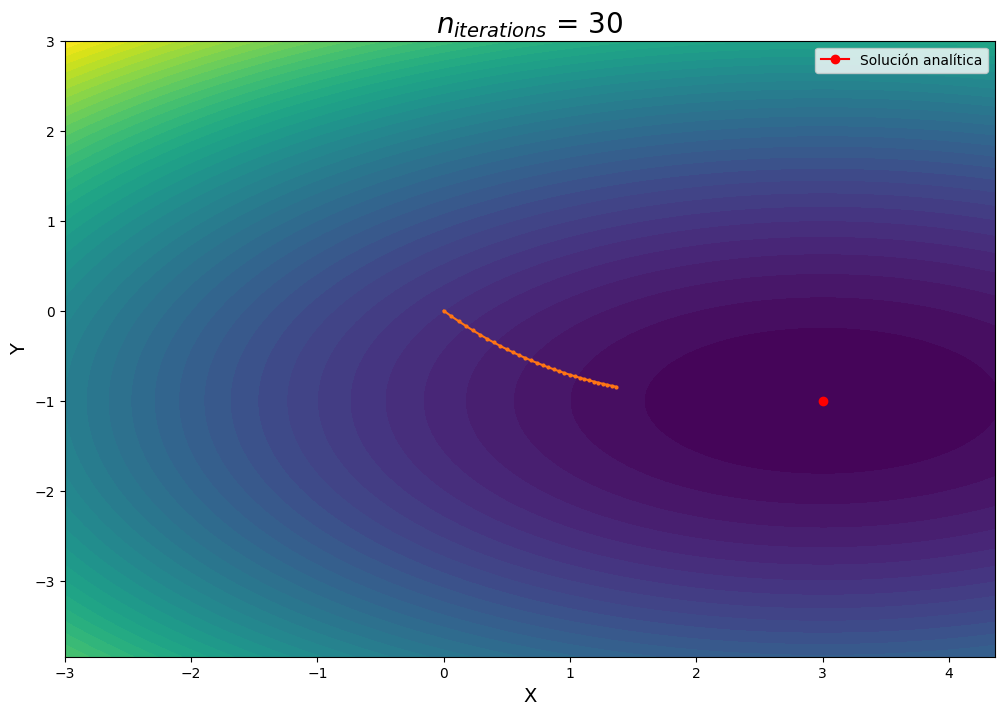

In [274]:
# Graficamos la función f1
x_range = np.linspace(min(x_values)-3, max(x_values)+3, 100)
y_range = np.linspace(min(y_values)-3, max(y_values)+3, 100)
xx, yy = np.meshgrid(x_range, y_range)
zz = f1(xx, yy)

fig, ax = plt.subplots(figsize=(12, 8))
plt.contourf(xx, yy, zz, levels=50)

# Graficamos la trayectoria del descenso de gradiente
plt.plot(x_values, y_values, marker="o", markersize=2, color='#FF7514')

# Graficamos la solución analítica
plt.plot(3, -1, marker="o", color='red', label='Solución analítica')

ax.set_title(u"$n_{iterations}$ = 30", fontsize=20)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_xlim(min(x_values)-3, max(x_values)+3)
ax.set_ylim(min(y_values)-3, max(y_values)+3)
ax.legend()
plt.show()

Ahora aplicaremos una versión del original descenso de gradiente denominada **"descenso de gradiente con momentum"**. Esta técnica acelera la convergencia del descenso de gradiente. En lugar de actualizar los parámetros en cada iteración basándose únicamente en el gradiente actual, el descenso de gradiente con momentum utiliza **una media ponderada de los gradientes anteriores para determinar la dirección de actualización**. En otras palabras, permite que el algoritmo tenga **"momentum" o inercia**. Este método actualiza el tamaño de paso de una manera **más efectiva y consciente que el decay** en la clase `StochasticGradientRegressor`.

Antes de probarlo con $f_{2}$, veamos cómo funciona este algoritmo con $f_{1}$ para poder comparar los algoritmos uno a uno.

x opt: 2.9873156588456142	y opt: -0.9956335825615529


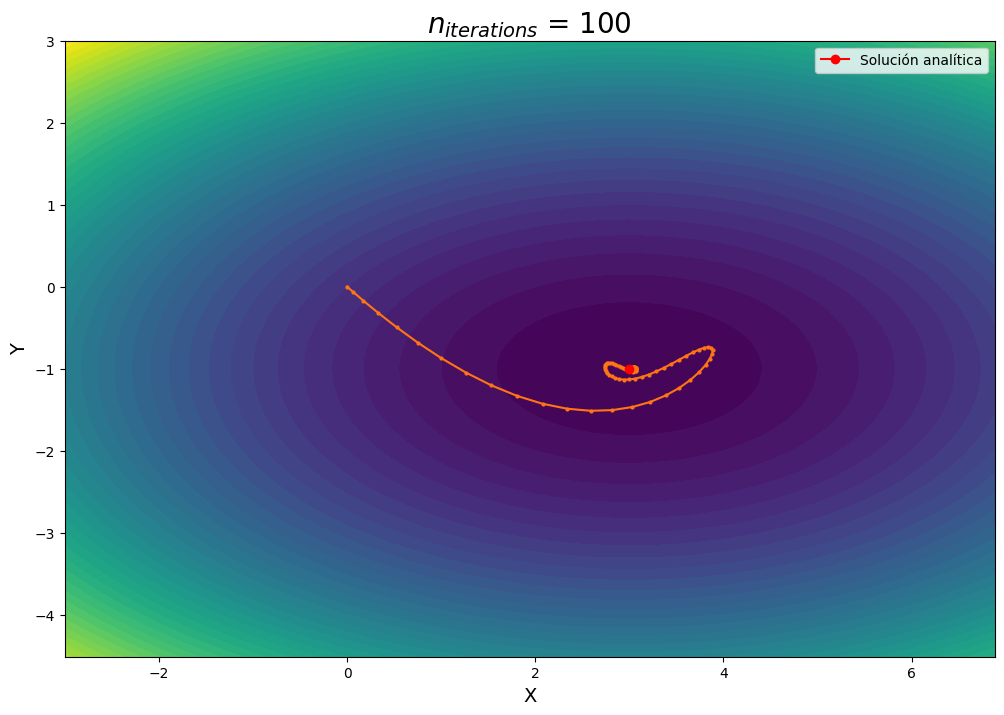

In [275]:
# Inicializamos los parámetros, el learning rate y el factor de momentum
x, y = 0, 0
lr = 0.01
gamma = 0.9

# Inicializamos el término de momentum
v = np.zeros(2)

# Listas para almacenar los valores del proceso de optimización
f_values = [f1(x, y)]
grad_norms = [np.linalg.norm(grad_f1(x, y))]
x_values = [x]
y_values = [y]

# Descenso de gradiente con momentum
for i in range(100):
    # Calculamos el gradiente y actualizamos los parámetros con momentum
    grad = grad_f1(x, y)
    v = gamma * v + lr * grad
    x -= v[0]
    y -= v[1]
    
    # Almacenamos los valores del proceso de optimización
    f_values.append(f1(x, y))
    grad_norms.append(np.linalg.norm(grad))
    x_values.append(x)
    y_values.append(y)
print(f"x opt: {x_values[-1]}\ty opt: {y_values[-1]}")

# Graficamos la función f1
x_range = np.linspace(min(x_values)-3, max(x_values)+3, 100)
y_range = np.linspace(min(y_values)-3, max(y_values)+3, 100)
xx, yy = np.meshgrid(x_range, y_range)
zz = f1(xx, yy)

fig, ax = plt.subplots(figsize=(12, 8))
plt.contourf(xx, yy, zz, levels=50)

# Graficamos la trayectoria del descenso de gradiente
plt.plot(x_values, y_values, marker="o", markersize=2, color='#FF7514')

# Graficamos la solución analítica
plt.plot(3, -1, marker="o", color='red', label='Solución analítica')

ax.set_title(u"$n_{iterations}$ = 100", fontsize=20)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_xlim(min(x_values)-3, max(x_values)+3)
ax.set_ylim(min(y_values)-3, max(y_values)+3)
ax.legend()
plt.show()

Como se puede apreciar este método es **mucho más preciso que el anterior**, y no únicamente por tener mayor número de iteraciones. Dejo al lector ver que con 30 iteraciones, este último algoritmo funciona de forma más precisa que el primero.

No solo es más preciso sino que tiene muchas **más ventajas**:
1. **Acelera la convergencia**: el uso de momentum permite que el algoritmo "adquiera impulso" y se mueva más rápido hacia el mínimo local, especialmente cuando la superficie de la función objetivo es muy irregular y hay muchos mínimos locales. En particular, el momentum ayuda a evitar que el algoritmo se quede atascado en mínimos locales poco profundos y permite una convergencia más rápida y estable.

2. **Mejora la estabilidad**: el momentum también ayuda a suavizar las oscilaciones en la dirección de actualización y permite una convergencia más estable. El momentum tiende a cancelar los cambios bruscos en la dirección de actualización que pueden ocurrir debido a la alta varianza en los gradientes, lo que hace que el algoritmo sea menos sensible a los cambios aleatorios en los datos de entrada.

Más información acerca de descenso de gradiente con momentum: https://towardsdatascience.com/gradient-descent-with-momentum-59420f626c8f

Ahora usemos este último método para la función $f_{2}$ y observemos qué tal funciona.

In [276]:
def f2(x, y):
    return (1 - (y - 3)) ** 2 + 10 * ((x + 4) - (y - 3) ** 2) ** 2

def grad_f2(x, y):
    return np.array([20 * (x + 4 - (y-3)**2), 
                     2*y - 8 + 10 * (12 - 4*y) * (x + 4 - (y - 3)**2)])

# Inicializamos los parámetros, el learning rate y el factor de momentum
x, y = 0, 2
lr = 0.01
gamma = 0.9

# Inicializamos el término de momentum
v = np.zeros(2)

# Listas para almacenar los valores del proceso de optimización
f_values = [f2(x, y)]
grad_norms = [np.linalg.norm(grad_f2(x, y))]
x_values = [x]
y_values = [y]

# Descenso de gradiente con momentum
for i in range(100):
    # Calculamos el gradiente y actualizamos los parámetros con momentum
    grad = grad_f2(x, y)
    v = gamma * v + lr * grad
    x -= v[0]
    y -= v[1]
    
    # Almacenamos los valores del proceso de optimización
    f_values.append(f2(x, y))
    grad_norms.append(np.linalg.norm(grad))
    x_values.append(x)
    y_values.append(y)
print(f"x opt: {x_values[-1]}\ty opt: {y_values[-1]}")

x opt: -3.0623184792791007	y opt: 3.9781844568872105


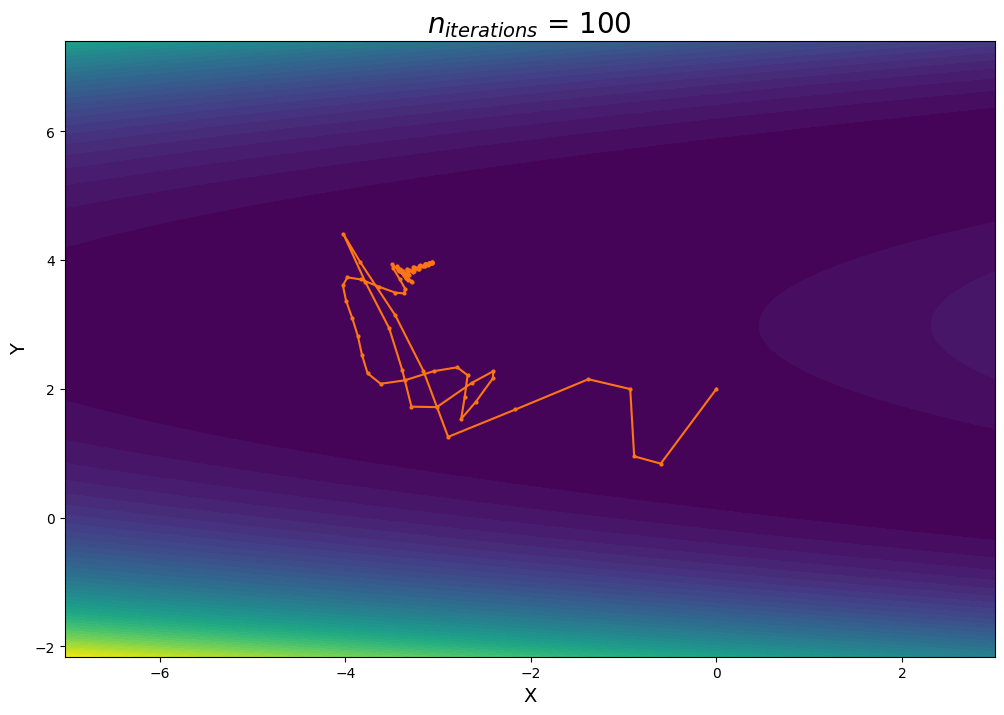

In [277]:
# Graficamos la función f2
x_range = np.linspace(min(x_values)-3, max(x_values)+3, 100)
y_range = np.linspace(min(y_values)-3, max(y_values)+3, 100)
xx, yy = np.meshgrid(x_range, y_range)
zz = f2(xx, yy)

fig, ax = plt.subplots(figsize=(12, 8))
plt.contourf(xx, yy, zz, levels=50)

# Graficamos la trayectoria del descenso de gradiente
plt.plot(x_values, y_values, marker="o", markersize=2, color='#FF7514')

ax.set_title(u"$n_{iterations}$ = 100", fontsize=20)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_xlim(min(x_values)-3, max(x_values)+3)
ax.set_ylim(min(y_values)-3, max(y_values)+3)
plt.show()

Ahora hallemos la **solución analítica**. Para encontrar el valor mínimo de la función $f_{2}$, debemos calcular sus derivadas parciales con respecto a $x$ e $y$, y resolver el sistema de ecuaciones resultante:

In [278]:
x, y = sp.symbols('x y')
f2 = (1 - (y - 3)) ** 2 + 10 * ((x + 4) - (y - 3) ** 2) ** 2
# Hallamos gradientes de la función
df2_dx = sp.diff(f2, x)
df2_dy = sp.diff(f2, y)
# Resolvemos el sistema
solutions = sp.solve([df2_dx, df2_dy], [x, y])

# Buscamos el mínimo de la función
min_value = float('inf')
min_point = None
for sol in solutions:
    value = f2.subs({x: sol[0], y: sol[1]})
    if value < min_value:
        min_value = value
        min_point = sol
min_point

(-3, 4)

Como la solución aproximada del último método se aproxima mucho y mejor a los resultado analíticos de las dos funciones, podemos concluir que el método de los momentos es un método más preciso y rápido que el algoritmo tradicional.

### 1.6. SVM:
Los métodos de descenso gradiente están en todos lados en el aprendizaje automático. Un ejemplo reciente importante para lo que hemos visto en este curso también es su uso en las Máquinas de Vector Soporte (SVMs), y más concretamente, en el clasificador de máximo margen (*maximal margin classifier*) y en su versión soft, que permite clasificar datos no linealmente separables (*soft margin classifier*). En general, los modelos tipo SVM intentan encontrar un hiperplano que maximice el margen entre dos clases, como hemos comentado ya previamente.

De acuerdo con lo visto en teoría, tenemos que minimizar la función objetivo de este algoritmo, la cual hemos definido como:
$$min_{\beta, \beta_{0}} \beta^{T}\beta + C\sum_{i=1}^{n}max[1-y_{i}(x\beta^{T} + \beta_{0}), 0]$$

El objetivo anterior consta de dos términos: el primero, que en general podría interpretarse como una regularización de Ridge, es el término que se asegura de que clasificamos con el máximo margen posible. Por otro lado, el segundo término. conocido como hinge loss, actúa como un término de ajuste, dándole peso a la clasificación correcta de los puntos, y cuya intensidad viene regulada por la constante C (si quieres ver más detalles puedes consultar los apuntes de clase, o bien el libro ISLR o el ESLII en las referencias de clase).

En este caso deberás crear un código donde se obtengan los coeficientes del hiperplano a partir del método del descenso de gradiente. Para minimizar esta función, necesitarás los gradientes de la función objetivo. La forma más sencilla de lidiar con este requerimiento, (aunque no la única) es calcularlos a mano con cuidado e implementar una función que evalúe la derivada en el punto que necesites en cada caso.

Para entrenar el clasificador usa los ficheros de datos que hemos incluido. Sus nombres explican para qué debes usar cada uno (X_train como inputs para entrenar, X_test para testear, y_train como targets para entrenar e y_test para testear). Evita estandarizar o aplicar ninguna otra transformación a los datos, úsalos tal cual están. Para cargarlos puedes usar la función de numpy `numpy.load`.

Aplica batch gradient descent al modelo con la función objetivo anterior empleando batches completos (es decir, usando todos los datos para el cálculo del gradiente, no minibatches ni stochastic GD). Para el ajuste, toma como punto inicial todos los parámetros inicializados en cero, C = 1 y como learning rate dale un valor pequeño, 0.001 por ejemplo, durante un número suficiente de iteraciones sobre el conjunto de datos (también llamado *épocas*), por ejemplo 1000. Muestra si el sistema ha terminado de converger a través de una figura donde representes la evolución de función los valores que va tomando la función de coste a medida que entrenas el sistema. Cuando obtengas la solución deberías tener 3 parámetros (dos componentes del vector **beta** y el sesgo, o **beta_0**).

Haz lo siguiente:
* Imprime por pantalla los valores de estos parámetros (o añádelos en el título o la leyenda de la figura del punto siguiente).
* Representa los datos de entrenamiento junto con el hiperplano de separación y los hiperplanos que definen el margen.
* Mide la accuracy de tu clasificador final en los puntos de test e imprímela en pantalla.
* Repite el segundo punto, pero en este caso con los datos de test.

**Extras:**
* ¿Qué efecto tiene la constante C en los resultados? Haz pruebas cambiando su valor y comenta qué observas.
* Si quieres, puedes probar otras configuraciones de learning rate y número de épocas asegurándote de que cuando lo entrenas un número de iteraciones suficiente consigues hacer que el sistema converja. ¿Podrías dar una solución mejor que la original? Y en cualquier caso, ¿en qué sentido sería mejor?
* ¿Qué pasa si los datos no tienen una linealidad inherente? ¿Cómo puede solucionarse este problema?

Antes de comenzar con el apartado, lo primero es cargar los datos de entrenamiento y validación.

In [279]:
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

$\providecommand{\norm}[1]{\lVert#1\rVert}$
El objetivo de este apartado es crear un modelo SVM que empleé descenso de gradiente estocástico para encontrar el hiperplano que mejor separe el conjunto de datos por etiquetas/clases. Este modelo viene dado por la clase `StochasticGradientSVM`.

Probablemente, os preguntéis **¿qué es un hiperplano?**
**Matemáticamente**, un hiperplano es un **subespacio de una dimensión menor a su espacio ambiente**. En un espacio euclídeo de dimensión $n$, el hiperplano se define como un subespacio de dimensión $n-1$. En un espacio unidimensional (una recta) el hiperplano es un punto (dimensión 1). De igual forma, en un espacio bidimensional, el hiperplano es una recta (dimensión 2) y en uno tridimensional, un plano tradicional.

Ahora veamos cómo se interpreta esto **en Aprendizaje Automático**:
En un modelo "bolsa de palabras" se convierten mensajes o textos en vectores característica, $x_{i}$  (feature vectors). Si estos ejemplos (mensajes) tienen etiquetas $y_{i}$, por ejemplo en "spam" y "no_spam", tenemos entonces un conjunto de datos compuesto de pares $\{x_{i}, y_{i}\}_{i=1}^{N}$, donde N es el conjunto de ejemplos que disponemos. A su vez los vectores característicos contienen valores por cada dimensión $j = 1,...,D$ donde $x^{(j)}$ se le denomina característica. En un modelo "bolsa de palabras" se hace una selección de palabras (características) que toman valor 0 o 1, dependiendo si el texto contiene o no las palabras. Si el modelo consta de 20.000 palabras ordenadas alfabéticamente obtendremos vectores de dimensión 20.000 (cada email sería un punto en un espacio de dimensión 20.000). Esta dimensión detemina la dimensión de nuestro espacio ambiente. Ahora para clasificar nuevos mensajes en "spam" (+1) y "no_spam" (-1) con un algoritmo de aprendizaje, por ejemplo SVM, necesitamos encontrar una línea imaginaria de dimensión 20.000 que separe los ejemplos en etiquetas positivas y negativas. A esta línea se la denomina hiperplano, y en Machine Learning los hiperplanos son considerados **fronteras que dividen los ejemplos en diferentes clases**. Un único hiperplano divide el espacio ambiente en dos mitades v.g. una línea divide el plano xy en dos planos mitad. El hiperplano que mejor separa los ejemplos en diferentes clases se le conoce como **frontera de decisión**.

En SVM cada vector característico se observa como un punto en un espacio de alta dimensionalidad. Como vimos, SVM tiene como objetivo encontrar el hiperplano que mejor separa estos puntos por etiquetas. La ecuación del hiperplano viende dada por $wx + b = 0$, donde $wx = w^{(1)}x^{(1)} + ... + w^{(D)}x^{(D)}$. Para encontrar la mejor frontera se deben encontrar los parámetros $w*$ y $b*$ óptimos tal que se obtiene un modelo $f(x) = sign(w*x - b*)$.

Para ello se necesita imponer unos requisitos, naturalmente:
$$
\begin{cases}
    wx_{i} - b \ge 1 & si & y_{i} = +1 \\
    wx_{i} - b \le -1, & si & y_{i} = -1
\end{cases}
$$

Otro interés a tener en cuenta es que nuestro hiperplano separase los ejemplos positivos y negativos con el mayor margen posible. ¿Por qué? Un mayor margen contribuyen a una mejor generalización para clasificar nuevos ejemplos. El margen viene dado por $\frac{2}{\norm{w}}$, donde $\norm{w}$ es la norma del vector $w$. Si tenemos en cuenta la norma euclideana, entonces $\norm{w} = \sqrt{\sum_{j=1}^{D}(w^{(j)})^{2}}$.

<p align="center">
    <!-- Ejemplo de modelo SVM en un espacio bidimensional -->
    <img src="images/image1.png">
</p>

Para **maximizar el margen**, hay, por tanto, que **minimizar la norma $\norm{w}$** obteniendo el siguiente criterio de optimización:
$$\min{\frac{1}{2}\norm{w}^{2} \text{ t.q. } y_{i}(wx_{i} - b) \ge 1}$$

A este hiperplano que mejor separa las clases (mayor margen) en un conjunto de datos se le denomina **Hiperplano de Margen Máximo**.

En resumen, el Hiperplano de Margen Máximo se utiliza en casos en los que el conjunto de datos es **linealmente separable**, es decir, que existe un hiperplano que puede separar perfectamente las dos clases de puntos de datos. Como se mencionó previamente, este hiperplano proporciona el **mejor rendimiento de generalización para clasificar nuevos ejemplos**. Para lidiar con el ruido y no linearidad se usan técnicas como la **pérdida bisagra (hinge loss)** o el **truco Kernel**.

Como se mencionó brevemente, hay <ins>**2 problemas fundamentales**</ins> que surgen de este planteamiento.
1. ¿Qué pasa si hay **ruido en los datos**? Con altos niveles de ruido no existe un hiperplano que clasifique perfectamente los ejemplos de entrenamiento.
2. ¿Qué pasa si **los datos no son linearmente separables**? El perfecto ejemplo son dos anillos centrados en un mismo eje, donde los puntos del anillo interior pertenecen a una clase y los del exterior a otra. En este ejemplo no existe una línea que separe perfectamente los datos, pero ¿qué pasa si tomamos polinomios de mayor orden (una circunferencia)?.

Ambos problemas pueden ser solucionados manteniendo las nociones vistas anteriormente. En el primer problema nos interesa **castigar de forma más intensa a aquellas predicciones incorrectas más alejadas del margen** (hinge loss function). Para lidiar con la no linealidad inherente se puede hacer uso de una función para **transformar implícitamente el espacio original en un espacio dimensional más alto**, "linealizando el espacio", durante la optimización de la función de coste (**kernel trick** o **truco kernel**). Esto último, hace computacionalmente realizable la idea de usar polinomios de mayor orden.

In [280]:
class StochasticGradientSVM:
    """
    Support Vector Machine (SVM) for binary classification using stochastic gradient descent.

    Methods
    -------
    fit(X, y)
        Fit the classification model to the given data.
    predict(X)
        Predict the class labels for the input data X using the trained linear classifier.
    """

    def __init__(self, C=1.0, tol=1e-4, max_epochs=1000, learning_rate=0.0001, batch_size=100,
                 regularization=None, reg_lambda=1.0, random_state=None, verbose=False):
        """
        Initializes a StochasticGradientSVM object.

        Parameters
        ----------
        C : float, default=1.0
            Penalty parameter C of the error term.
        tol : float, default=1e-4
            Tolerance for stopping criterion.
        max_epochs : int, default=1000
            Maximum number of epochs (passes over the training data).
        learning_rate : float, default=0.0001
            Learning rate for the gradient descent optimizer.
        batch_size : int, default=100
            Number of samples to use in each batch for stochastic gradient descent.
        regularization : {'l1', 'l2', 'elastic_net', None}, default=None
            Type of regularization to apply on the weights.
        reg_lambda : float, default=1.0
            Regularization strength. Larger values imply stronger regularization.
        random_state : int or None, default=None
            Seed of the pseudo random number generator used for shuffling the data.
        verbose : bool, default=False
            Whether to print progress messages during training.
        """

        self.C = C
        self.tol = tol
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.random_state = random_state
        self.verbose = verbose
        self.beta = None
        self.beta_0 = None

    def _compute_loss(self, X, y):
        """
        Computes the hinge loss and regularization loss.

        Parameters
        ----------
        X : array-like of shape (n_samples,n_features)
            Training data.
        y: array-like of shape(n_samples,)
            Target values.

        Returns
        -------
        loss: float
            The hinge loss plus the regularization loss.
        """

        margin = 1 - y * (np.dot(X, self.beta) + self.beta_0)
        hinge_loss = np.maximum(0, margin) ** 2
        if self.regularization == 'l1':
            reg_loss = self.reg_lambda * np.abs(self.beta).sum()
        elif self.regularization == 'l2':
            reg_loss = 0.5 * self.reg_lambda * (self.beta ** 2).sum()
        elif self.regularization == 'elastic_net':
            reg_loss = self.reg_lambda * (0.5 * (self.beta ** 2).sum() + np.abs(self.beta).sum())
        else:
            reg_loss = 0
        return self.C * hinge_loss.sum() + reg_loss

    def _compute_gradient(self, X, y):
        """
        Computes the gradient of the loss function with respect to beta and beta_0.

        Parameters
        ----------
        X: array-like of shape(n_samples,n_features)
            Training data.
        y: array-like of shape(n_samples,)
            Target values.

        Returns
        -------
        d_beta: array-like of shape(n_features,)
            Gradient with respect to beta.
        d_beta_0: float
            Gradient with respect to beta_0.
        """

        margin = 1 - y * (np.dot(X, self.beta) + self.beta_0)
        margin = margin[:, np.newaxis]
        d_beta = -2 * self.C * np.mean((margin > 0) * y[:, np.newaxis] * X, axis=0)
        d_beta_0 = -2 * self.C * np.mean((margin > 0) * y)
        if self.regularization == 'l1':
            d_beta += self.reg_lambda * np.sign(self.beta)
        elif self.regularization == 'l2':
            d_beta += self.reg_lambda * self.beta
        elif self.regularization == 'elastic_net':
            d_beta += self.reg_lambda * (self.beta + np.sign(self.beta))
        return d_beta, d_beta_0

    def fit(self, X, y):
        """
        Fit the SVM model according to the given training data.

        Parameters
        ----------
        X: array-like of shape(n_samples,n_features)
            Training data.
        y: array-like of shape(n_samples,)
            Target values.

        Returns
        -------
        beta: ndarray of shape (n_features,)
            Returns beta vector
        d_beta_0: float
            Returns beta_0
        """

        n_samples, n_features = X.shape
        self.beta = np.zeros(n_features)
        self.beta_0 = 0
        rng = np.random.default_rng(self.random_state)
        for epoch in range(self.max_epochs):
            shuffled_indices = rng.permutation(n_samples)
            for i in range(0, n_samples, self.batch_size):
                indices = shuffled_indices[i:i + self.batch_size]
                X_batch, y_batch = X[indices], y[indices]
                d_beta, d_beta_0 = self._compute_gradient(X_batch, y_batch)
                self.beta -= self.learning_rate * d_beta
                self.beta_0 -= self.learning_rate * d_beta_0

            if epoch % 100 == 0 and epoch > 0 and self.verbose:
                loss = self._compute_loss(X, y)
                print(f'Epoch {epoch}/{self.max_epochs} | Loss: {loss:.6f}')
        return self.beta, self.beta_0

    def predict(self, X):
        """
        Perform classification on samples in X.

        Parameters
        ----------
        X: array-like of shape(n_samples,n_features)
          Samples.

        Returns
        -------
        y_pred: array-like of shape(n_samples,)
            Class labels for samples in X.

        Raises
        ------
        ModelNotTrainedError : if self.beta or self.beta_0 are None
            If the linear classifier has not been fitted (i.e., trained) yet,
            attempting to predict with it will raise a ModelNotTrainedError.
        """

        if self.beta is None or self.beta_0 is None:
            raise ModelNotTrainedError
        return np.sign(np.dot(X, self.beta) + self.beta_0)


En el algoritmo de SVM, el hiperplano que separa las dos clases se define mediante una función lineal de la forma:
$$y(x) = w^T x + b$$

Donde w es un vector normal al hiperplano y b es el término de sesgo (bias). En el caso de SVM con kernel, la función de decisión se reescribe como:

$$y(x) = \sum_i (\beta_i * y_i * K(x_i, x)) + \beta_0$$

Donde $K(x_i, x)$ es el kernel que mide la similitud entre $x$ y $x_i$, $\beta_i$ es un coeficiente asociado a cada vector de soporte $x_i$ de la muestra de entrenamiento, y $y_i$ es la etiqueta de clase asociada a $x_i$. $\beta_0$ es un término constante que se añade para mover el hiperplano de tal manera que quede equidistante de los vectores de soporte más cercanos.

En `StochasticGradientSVM`, **beta y beta_0 son los parámetros del modelo que se ajustan durante el entrenamiento para encontrar el hiperplano óptimo**. beta es un vector de coeficientes asociados a los vectores de soporte, y beta_0 es el término constante que se añade a la función de decisión. Después de entrenar el modelo, estos parámetros se utilizan para hacer predicciones sobre nuevos datos.

Además, este modelo implementado tiene una serie de **nuevos hiperparámetros** que explicaremos a continuación uno a uno p.ej. $C$. Otros hiperparámetros como son **tol, regularization o learning rate**, ya deben resultaros familiares de anteriores apartados.

$\providecommand{\norm}[1]{\lVert#1\rVert}$
**Recordatorio**:
<br>
Para encontrar la mejor frontera se deben encontrar los parámetros $w*$ y $b*$ óptimos tal que se obtiene un modelo $f(x) = sign(w*x - b*)$. Para ello se necesita imponer unos requisitos, naturalmente:
$$
\begin{cases}
    wx_{i} - b \ge 1 & si & y_{i} = +1 & \text{(Condición A)}\\
    wx_{i} - b \le -1, & si & y_{i} = -1 & \text{(Condición B)}
\end{cases}
$$
<br/>

**¿Qué es el hiperparámetro $C$?**

Ya mencionamos que para lidiar con el ruido nuestro objetivo era **penalizar a aquellas predicciones incorrectas más alejadas del margen**. Para ello utilizamos **la pérdida bisagra (hinge loss)**:
$$\max{(0, 1-y_{i}(wx_{i}-b))}$$
Nótese que cuando las condiciones $A$ y $B$ se cumplan entonces la función valdrá 0, en caso contrario esta será proporcional a la distancia del punto con la frontera.

Por tanto nuestra nueva función de cose es: $C\norm{w}^{2}+\frac{1}{N}\sum_{i=1}^{N}\max{(0, 1-y_{i}(wx_{i}-b))}$,
donde **$C$ es un hiperparámetro que se obtiene mediante cross-validation**.

$C$ determina la compensación entre:
1. incrementar el tamaño de la frontera de decisión
2. asegurar que los $x_{i}$ se encuentrar corréctamente clasificados

Valores altos de $C$ hacen que el segundo término de la función de coste (hinge loss) sea menos relevante, o casi despreciable (el algoritmo buscará el margen que separe perfectamente los datos). Valores bajos de $C$ dan más importancia a la pérdida bisagra, penalizando más a aquellos puntos mal clasificados y más alejados de la frontera.

**Nota:** Los efectos de esto último los probaremos en futuros apartados.

Esta nueva formulación de SVM se la conoce como **soft-margin SVM** y a la anterior, o como se la llamaba en el apartado anterior MMC, **hard-margin SVM**.

Ya es hora de probar la clase `StochasticGradientSVM`, entrenando el modelo con los datos de entrenamiento cargados previamente.

In [281]:
# Crear una instancia de la clase `StochasticGradientSVM`
svm = StochasticGradientSVM(regularization='l2', max_epochs=1000, random_state=42)

# Entrenamos el modelo con los datos de entrendamiento
beta, beta_0 = svm.fit(X_train, y_train)
print(f"Beta: {beta}\tBeta_0: {beta_0}")

Beta: [0.31535345 0.10223942]	Beta_0: 0.004133119999999981


Los valores de $\beta$ y $\beta_0$ obtenidos son aproximadamente:
$$\beta =\begin{pmatrix}0.0760 \\ 0.0414\end{pmatrix} \quad \beta_0: 0.0008$$

Ahora veamos con qué **precisión** etiqueta el modelo los datos de validación, con el hiperplano hallado.

In [282]:
# Calcular las predicciones del modelo
y_pred = svm.predict(X_test)

# Comparar las predicciones con las etiquetas verdaderas
correct_predictions = 0
for i in range(len(y_test)):
    if y_pred[i] == y_test[i]:
        correct_predictions += 1

# Calcular la precisión
accuracy = correct_predictions / len(y_test)
print('Precisión del modelo:', accuracy)

Precisión del modelo: 1.0


La precisión es 1.0, lo que indica que nuestro modelo **clasifica los puntos de validación con una precisión perfecta**. En otras palabras, el modelo no etiqueta mal ningún punto del conjunto. Podemos observar esto gráficamente. Primero veamos **cómo el hiperplano clasifica el conjunto de entrenamiento**.

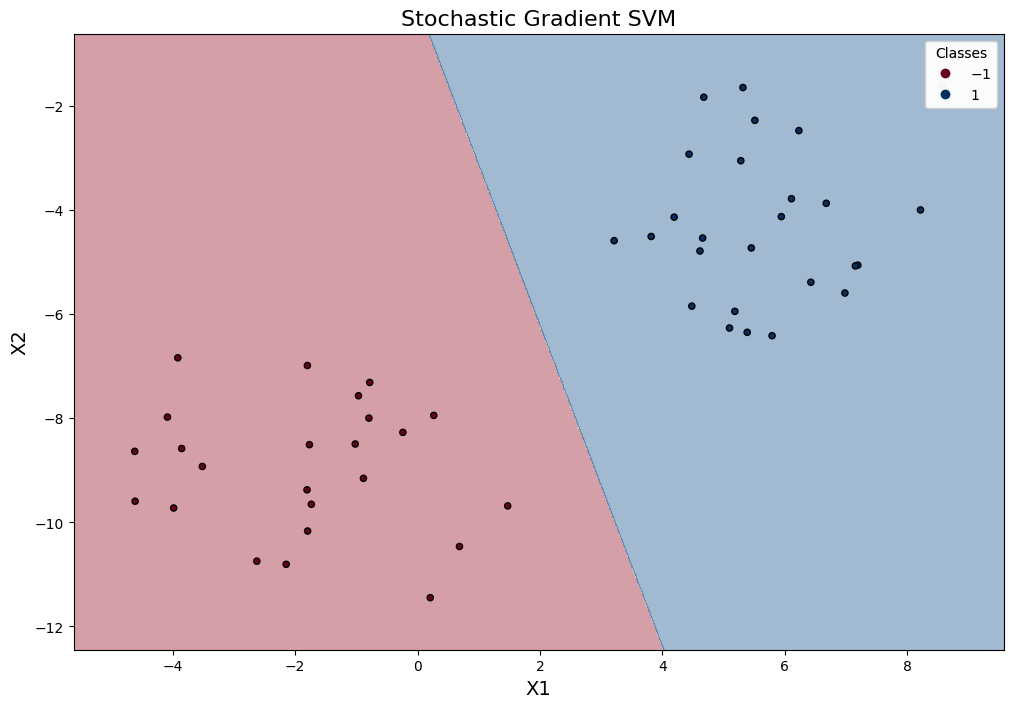

In [283]:
# Graficamos frontera de decisión
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
# Reordenamos los datos del meshgrid para tener una lista de ejemplos/puntos sin etiquetar
X_grid = np.c_[xx.ravel(), yy.ravel()]
zz = svm.predict(X_grid)
zz = zz.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
plt.contourf(xx, yy, zz, alpha=0.4, cmap='RdBu')

# Graficamos los puntos de entrenamiento
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                      s=20, cmap='RdBu', edgecolors='k', vmin=-1, vmax=1)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.title('Stochastic Gradient SVM', fontsize=16)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show()

Como se puede observar en la gráfica el modelo también dispone de **una precisión de 1.0 sobre el conjunto de entrenamiento**. Ahora veamos **qué tal clasifica los puntos de validación**.

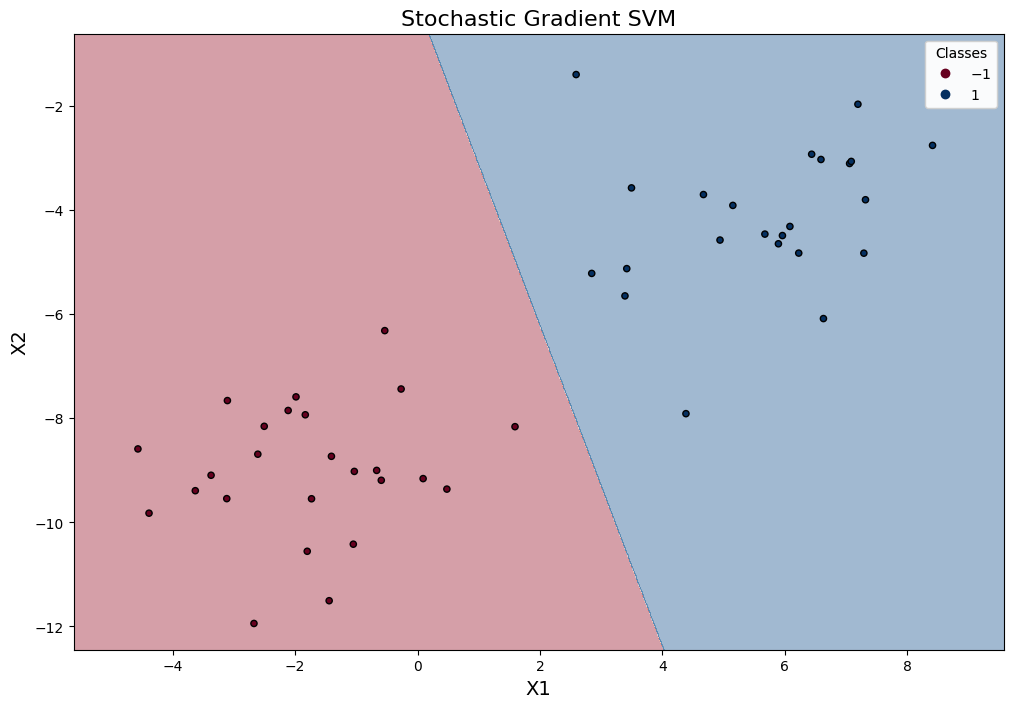

In [284]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.contourf(xx, yy, zz, alpha=0.4, cmap='RdBu')

# Graficamos los puntos de validacion
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
                      s=20, cmap='RdBu', edgecolors='k', vmin=-1, vmax=1)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.title('Stochastic Gradient SVM', fontsize=16)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show()

Como se menciono anteriormente, el modelo clasifica perfectamente los puntos de `X_test`.

Por último observemos cómo variar el hiperparámetro $C$ afecta a la clasificación del modelo (sobre el conjunto de entrenamiento). Para ello generaremos un nuevo conjunto de datos más ruidoso, donde no exista una frontera que separe el conjunto de entrenamiento con precisión perfecta.

Para C=0.1Beta: [0.23530666 0.23442983]	Beta_0: 1.8755999999999984e-05	Accuracy on train: 0.918
Para C=1.0Beta: [0.47525208 0.46951525]	Beta_0: 0.00022200000000000033	Accuracy on train: 0.917
Para C=10Beta: [0.59234064 0.58972343]	Beta_0: 0.003711600000000003	Accuracy on train: 0.919
Para C=100Beta: [0.59113893 0.60497765]	Beta_0: 0.039943999999999744	Accuracy on train: 0.918


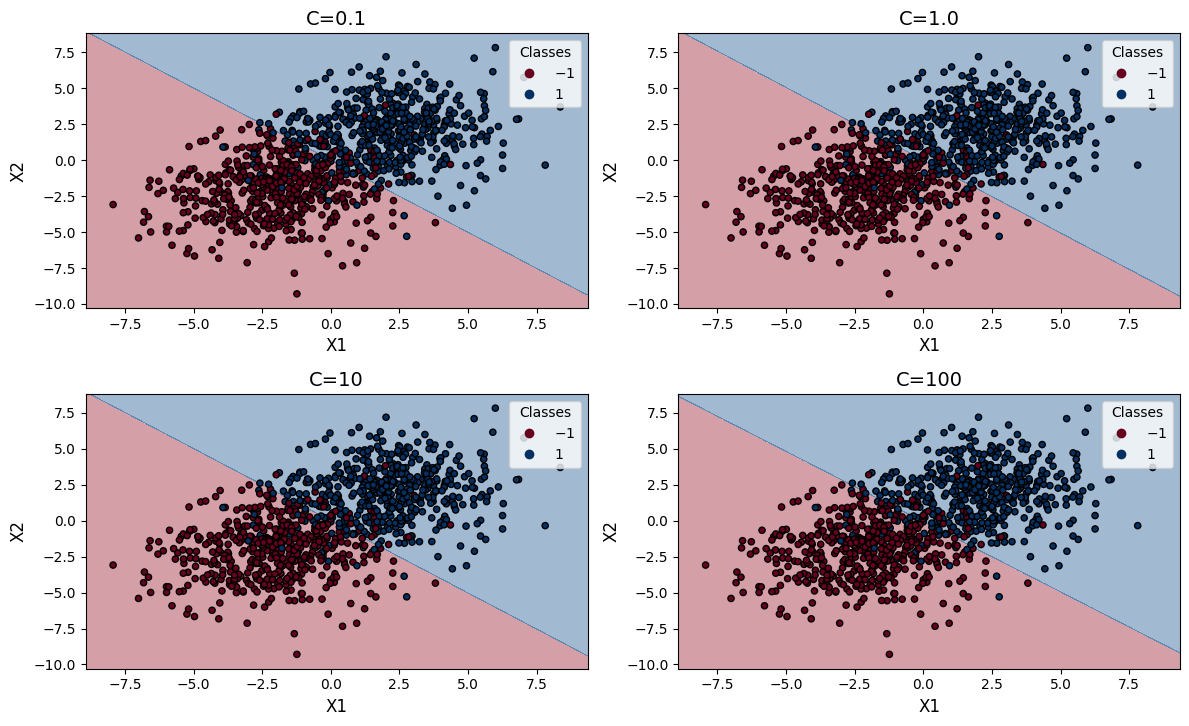

In [285]:
# Definir número de ejemplos
n = 1000

# Definir una función que crea puntos aleatorios en torno a un centro
def make_points(n, center):
    rng = np.random.default_rng(42)
    return rng.normal(loc=center, scale=2.0, size=(n, 2))

# Crear dos grupos de puntos centrados en (2,2) y (-2,-2)
X1 = make_points(n//2, (2, 2))
X2 = make_points(n//2, (-2, -2))

# Introducir ruido en los datos mezclando aleatoriamente los puntos entre las dos clases
X_train = np.concatenate([X1, X2], axis=0)
y_train = np.concatenate([np.ones((n//2, 1)), -np.ones((n//2, 1))], axis=0)
permutation = np.random.permutation(n)
X_train = X_train[permutation]
y_train = y_train[permutation]
y_train = y_train.flatten()

# Definimos una lista de valores de C a probar
C_values = [0.1, 1.0, 10, 100]

# Creamos una figura con 4 subplots para visualizar las distintas fronteras
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Iteramos sobre los valores de C y graficamos la frontera de decisión en cada subplot
for i, C in enumerate(C_values):
    # Creamos una instancia de la clase `StochasticGradientSVM` con el valor de C correspondiente
    svm = StochasticGradientSVM(max_epochs=1000, C=C, random_state=42)

    # Entrenamos el modelo con los datos de entrenamiento
    beta, beta_0 = svm.fit(X_train, y_train)

    # Calcular las predicciones del modelo para el conjunto de entrenamiento
    y_pred = svm.predict(X_train)

    # Comparar las predicciones con las etiquetas verdaderas
    correct_predictions = 0
    for j in range(len(y_train)):
        if y_pred[j] == y_train[j]:
            correct_predictions += 1

    # Calcular la precisión
    accuracy = correct_predictions / len(y_train)
    print(f"Para C={C}Beta: {beta}\tBeta_0: {beta_0}\tAccuracy on train: {accuracy}")
    
    # Graficamos la frontera de decisión en el subplot correspondiente
    ax = axs[i // 2, i % 2]
    zz = svm.predict(X_grid)
    zz = zz.reshape(xx.shape)
    ax.contourf(xx, yy, zz, alpha=0.4, cmap='RdBu')
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, cmap='RdBu', edgecolors='k', vmin=-1, vmax=1)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('X1', fontsize=12)
    ax.set_ylabel('X2', fontsize=12)
    ax.set_title(f'C={C}', fontsize=14)
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")

# Ajustamos los subplots para que no se superpongan los títulos
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

En este caso, parece que **a medida que aumenta el valor de $C$, también aumenta la magnitud de los parámetros $\beta$ y $\beta_0$**. Esto sugiere que a medida que $C$ aumenta, el modelo está poniendo **más énfasis en minimizar el error de clasificación y está dispuesto a aceptar un margen más pequeño para ajustarse mejor a los datos de entrenamiento**.

Sin embargo, es importante tener en cuenta que **la precisión en los datos de entrenamiento permanece relativamente constante a medida que cambia C**. Esto sugiere que <ins>el modelo puede lograr un rendimiento similar en los datos de entrenamiento independientemente del valor de $C$</ins>. Es posible que para este conjunto de datos en particular, la elección de C no sea crítica y una amplia gama de valores puedan lograr un rendimiento similar.

En todo caso la mejor forma de obtener el valor de $C$, como de cualquier otro hiperparámetro, es usando técnicas de validación cruzada.

Ahora recordemos que las máquinas de vector soporte tenían dos problemas fundamentales. El primero lo logramos solucionar gracias al hiperparámetro $C$. El segundo era ¿Qué pasaría si **los datos no son linearmente separables**? En este caso se utiliza lo que se conoce como **truco kernel**.

**¿Qué es un kernel en máquinas de vector soporte?**

Las SVMs pueden adaptarse para trabajar con conjuntos de datos que no pueden separarse linealmente por un hiperplano en su espacio original. Esto hasta ahora no puede ser realizado por los anteriores clasificadores.
<p align="center">
    <!-- Ejemplo de conjunto de datos no linealmente separables -->
    <img src="images/image2.png">
</p>

Para ello SVM, hace uso de una función para **transformar implícitamente el espacio original en un espacio dimensional más alto**, "linealizando el espacio", durante la optimización de la función de coste (**truco kernel** o **kernel trick**). Esto último, hace computacionalmente realizable la idea de usar polinomios de mayor orden.
<p align="center">
    <!-- Ejemplo de transformación implícita del espacio original para lograr linealidad -->
    <img src="images/image3.png">
</p>

Esta transformación viene dada por $\phi: x \mapsto \phi(x)$, donde $\phi(x)$ es un vector de mayor dimensión que $x$. Por ejemplo, si $x = [q, p]$, en un espacio tridimensional $\phi([q, p])=(q^{2}, \sqrt{2}qp, p^{2})$.

Para resolver el problema de optimización que conlleva encontrar $\phi$ se hace uso del [**método de los multiplicadores de Lagrange**](https://es.wikipedia.org/wiki/Multiplicadores_de_Lagrange).

En resumen, un kernel es una **función matemática que se utiliza para medir la similitud entre dos vectores de características en un espacio de alta dimensión**. La función de kernel mapea los datos de entrada a un espacio de características de alta dimensión, donde los datos son más fáciles de clasificar. Esto se logra mediante el uso de una función de transformación no lineal para transformar los datos de entrada a un espacio de características de mayor dimensión.

Hay muchos kernels a elegir. En la clase `StochasticGradientSVM` vamos a implementar algunos de los más conocidos como son:
* **Linear**: Este kernel se usa cuando los datos son linealmente separables. La función de kernel se define como el producto escalar de dos vectores: $K(x, x') = x^T x'$
* **Polynomial (Polinómico)**: Este kernel se utiliza para encontrar un hiperplano de decisión de mayor dimensión en un espacio de características más alto. La función de kernel se define como $(\gamma x^T x' + r)^d$, donde $\gamma$ es el coeficiente, $r$ es el término independiente en la función y $d$ es el grado del polinomio.
* **RBF (Radial basis function)**: Este kernel es útil cuando los datos no son linealmente separables y se usa para mapear los datos a una dimensión superior. La función de kernel se define como $K(x, x') = e^{-\gamma ||x - x'||^2}$, donde $\gamma$ es el coeficiente.
* **Sigmoidal**: Este kernel también se utiliza para encontrar un hiperplano de decisión de mayor dimensión en un espacio de características más alto. La función de kernel se define como $\tanh(\gamma x^T x' + r)$, donde $\gamma$ es el coeficiente y $r$ es el término independiente en la función.

Los parámetros que se pueden ajustar para cada kernel son los siguientes:
* `degree`: Grado del polinomio en el kernel polinómico. El valor predeterminado es 3.
* `gamma`: Coeficiente del kernel RBF, polinómico y sigmoide. Si se establece en "scale", se utiliza $\gamma = \frac{1}{n_{features} * X.var ()}$ para RBF, y $\gamma = \frac{1}{n_{features}}$ para polinómico y sigmoide. Si se establece en "auto", se utiliza $\gamma = \frac{1}{n_{features}}$. Si se establece en un valor flotante, se utiliza ese valor como gamma. El valor predeterminado es "scale".
* `coef0`: Término independiente en la función del kernel RBF, polinómico y sigmoide. El valor predeterminado es 0.0.

In [286]:
class StochasticGradientSVM:
    """
    Support Vector Machine (SVM) for binary classification using stochastic gradient descent.

    Methods
    -------
    fit(X, y)
        Fit the classification model to the given data.
    predict(X)
        Predict the class labels for the input data X using the trained linear classifier.
    """

    def __init__(self, C=1.0, tol=1e-4, max_epochs=1000, kernel='linear', gamma='scale', coef0=0.0, degree=3,
                 learning_rate=0.0001, batch_size=100, regularization=None, reg_lambda=1.0,
                 random_state=None, verbose=False):
        """
        Initializes a StochasticGradientSVM object.

        Parameters
        ----------
        C : float, default=1.0
            Penalty parameter C of the error term.
        tol : float, default=1e-4
            Tolerance for stopping criterion.
        max_epochs : int, default=1000
            Maximum number of epochs (passes over the training data).
        kernel : str, default='linear'
            Type of kernel to use ('linear', 'rbf', 'poly' or 'sigmoid').
        gamma : {'scale', 'auto'} or float, default='scale'
            Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
        coef0 : float, default=0.0
            Independent term in kernel function. It is only significant in 'poly' and 'sigmoid'.
        degree : int, default=3
            Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
        learning_rate : float, default=0.0001
            Learning rate for the gradient descent optimizer.
        batch_size : int, default=100
            Number of samples to use in each batch for stochastic gradient descent.
        regularization : {'l1', 'l2', 'elastic_net', None}, default=None
            Type of regularization to apply on the weights.
        reg_lambda : float, default=1.0
            Regularization strength. Larger values imply stronger regularization.
        random_state : int or None, default=None
            Seed of the pseudo random number generator used for shuffling the data.
        verbose : bool, default=False
            Whether to print progress messages during training.
        """

        self.C = C
        self.tol = tol
        self.max_epochs = max_epochs
        self.kernel = kernel
        self.gamma = gamma
        self.coef0 = coef0
        self.degree = degree
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.random_state = random_state
        self.verbose = verbose
        self.X_fit_ = None
        self.beta = None
        self.beta_0 = None

    def _compute_kernel(self, X1, X2=None):
        """
        Compute the kernel matrix between X1 and X2.

        Parameters
        ----------
        X1: array-like of shape (n_samples_1, n_features)
            First data matrix.
        X2: array-like of shape (n_samples_2, n_features), default=None
            Second data matrix. If None, use X1.

        Returns
        -------
        K: ndarray of shape (n_samples_1, n_samples_2)
            Kernel matrix.
        """

        if X2 is None:
            X2 = X1
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'rbf':
            if self.gamma == 'scale':
                gamma = 1 / (X1.shape[1] * X1.var())
            elif self.gamma == 'auto':
                gamma = 1 / X1.shape[1]
            else:
                gamma = self.gamma
            XX1T = np.dot(X1, X2.T)
            XX2T = np.dot(X2, X2.T)
            XX1_sqnorms = np.diag(XX1T)
            XX2_sqnorms = np.diag(XX2T)
            K = -2 * XX1T + XX1_sqnorms[:, np.newaxis] + XX2_sqnorms[np.newaxis, :]
            K *= -gamma
            np.exp(K,K)
            return K
        elif self.kernel == 'poly':
            return (np.dot(X1, X2.T) + self.coef0)**self.degree
        elif self.kernel == 'sigmoid':
            return np.tanh(np.dot(X1, X2.T)*self.gamma+self.coef0)

    def _compute_loss(self, X, y):
        """
        Computes the hinge loss and regularization loss.

        Parameters
        ----------
        X : array-like of shape (n_samples,n_features)
            Training data.
        y: array-like of shape(n_samples,)
            Target values.

        Returns
        -------
        loss: float
            The hinge loss plus the regularization loss.
        """

        K = self._compute_kernel(X)
        margin = 1 - y * (np.dot(K, self.beta) + self.beta_0)
        hinge_loss = np.maximum(0, margin) ** 2
        if self.regularization == 'l1':
            reg_loss = self.reg_lambda * np.abs(self.beta).sum()
        elif self.regularization == 'l2':
            reg_loss = 0.5 * self.reg_lambda * (self.beta ** 2).sum()
        elif self.regularization == 'elastic_net':
            reg_loss = self.reg_lambda * (0.5 * (self.beta ** 2).sum() + np.abs(self.beta).sum())
        else:
            reg_loss = 0
        return self.C * hinge_loss.sum() + reg_loss

    def _compute_gradient(self, K, y, indices):
        """
        Computes the gradient of the loss function with respect to beta and beta_0.

        Parameters
        ----------
        K: ndarray of shape (n_samples, n_samples)
            Kernel matrix.
        y: array-like of shape (n_samples,)
            Labels.
        indices: array-like of shape (batch_size,)
            Indices of the current batch.

        Returns
        -------
        d_beta: ndarray of shape (n_samples,)
            Gradient with respect to beta.
        d_beta_0: float
            Gradient with respect to beta_0.
        """

        margin = 1 - y[indices] * (np.dot(K[indices], self.beta) + self.beta_0)
        margin = margin[:, np.newaxis]
        d_beta = -2 * self.C * np.mean((margin > 0) * y[indices][:, np.newaxis] * K[indices], axis=0)
        d_beta_0 = -2 * self.C * np.mean((margin > 0) * y[indices])
        if self.regularization == 'l1':
            d_beta += self.reg_lambda * np.sign(self.beta)
        elif self.regularization == 'l2':
            d_beta += self.reg_lambda * self.beta
        elif self.regularization == 'elastic_net':
            d_beta += self.reg_lambda * (self.beta + np.sign(self.beta))
        return d_beta, d_beta_0

    def fit(self, X, y):
        """
        Fit the SVM model according to the given training data.

        Parameters
        ----------
        X: array-like of shape(n_samples,n_features)
            Training data.
        y: array-like of shape(n_samples,)
            Target values.

        Returns
        -------
        beta: ndarray of shape (n_samples,)
            Returns beta vector
        d_beta_0: float
            Returns beta_0
        """

        n_samples, n_features = X.shape
        K = self._compute_kernel(X)
        self.X_fit_ = X
        self.beta = np.zeros(n_samples)
        self.beta_0 = 0
        rng = np.random.default_rng(self.random_state)
        for epoch in range(self.max_epochs):
            shuffled_indices = rng.permutation(n_samples)
            for i in range(0, n_samples, self.batch_size):
                indices = shuffled_indices[i:i + self.batch_size]
                d_beta, d_beta_0 = self._compute_gradient(K, y, indices)
                self.beta -= self.learning_rate*d_beta
                self.beta_0 -= self.learning_rate*d_beta_0

            if epoch % 100 == 0 and epoch > 0 and self.verbose:
                loss = self._compute_loss(K, y)
                print(f'Epoch {epoch}/{self.max_epochs} | Loss: {loss:.6f}')
        return self.beta, self.beta_0

    def predict(self, X):
        """
        Perform classification on samples in X.

        Parameters
        ----------
        X: array-like of shape(n_samples,n_features)
          Samples.

        Returns
        -------
        y_pred: array-like of shape(n_samples,)
            Class labels for samples in X.

        Raises
        ------
        ModelNotTrainedError : if self.beta or self.beta_0 are None
            If the linear classifier has not been fitted (i.e., trained) yet,
            attempting to predict with it will raise a ModelNotTrainedError.
        """

        if self.beta is None or self.beta_0 is None:
            raise ModelNotTrainedError
        K = self._compute_kernel(self.X_fit_, X)
        return np.sign(np.dot(K.T, self.beta) + self.beta_0)

Para probar la versión definitiva de `StochasticGradientSVM` generaremos un conjunto de datos no linealmente separable. El perfecto ejemplo son dos anillos centrados en un mismo eje, donde los puntos del anillo interior pertenecen a una clase y los del exterior a otra. En este caso utilizaremos dos distribuciones circulares concéntricas.

**Nota:** En esta nueva implementación los coeficientes beta y beta_0 dejan de ser tan interpretables ya que ahora beta es un vector que toma de tamaño el número de ejemplos de entrenamiento. Esto permite poder trabajar con los kernels de una forma cómoda y viable.
**Warning:** En esta implementación recomiendo ser moderado con la cantidad de datos de entrenamiento y validación, ya que con kernels como el RBF es muy posible toparse con errores de exceso de memoria (con cientos de miles de datos).

Para kernel=linear, Accuracy on train: 0.5
Para kernel=rbf, Accuracy on train: 0.5
Para kernel=poly, Accuracy on train: 0.522
Para kernel=sigmoid, Accuracy on train: 0.5


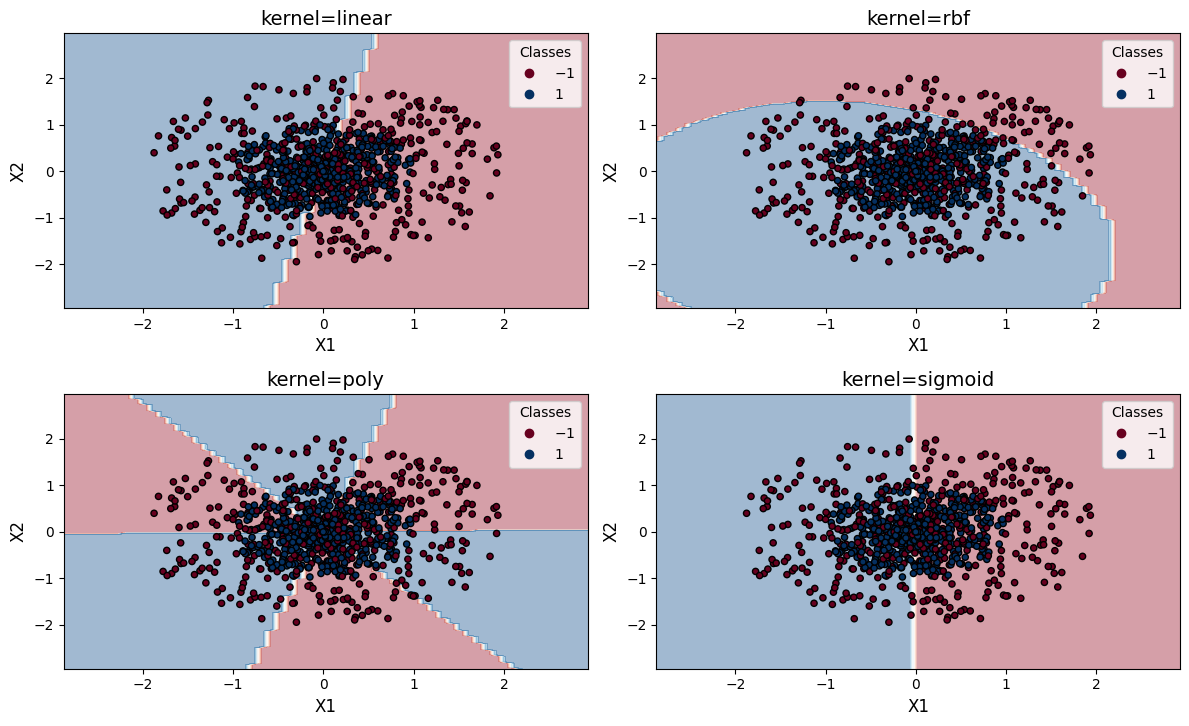

In [287]:
# Definir número de ejemplos
n = 1000

# Definir una función que crea puntos aleatorios en un círculo
def make_points(n, radius):
    rng = np.random.default_rng(42)
    theta = 2 * np.pi * rng.random(n)
    r = radius * rng.random(n)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

# Crear dos grupos de puntos en círculos concéntricos
X1 = make_points(n//2, 1.0)
X2 = make_points(n//2, 2.0)

# Introducir ruido en los datos mezclando aleatoriamente los puntos entre las dos clases
X_train = np.concatenate([X1, X2], axis=0)
X_train = X_train.astype(float)
y_train = np.concatenate([np.ones((n//2, 1)), -np.ones((n//2, 1))], axis=0)
permutation = np.random.permutation(n)
X_train = X_train[permutation]
y_train = y_train[permutation]
y_train = y_train.flatten()

# Definimos una lista de valores de C a probar
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Creamos una figura con 4 subplots para visualizar las distintas fronteras
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.03))
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Iteramos sobre los valores de C y graficamos la frontera de decisión en cada subplot
for i, kernel in enumerate(kernels):
    # Creamos una instancia de la clase `StochasticGradientSVM` con el valor de C correspondiente
    svm = StochasticGradientSVM(kernel=kernel, gamma=0.1, max_epochs=1000, random_state=42)

    # Entrenamos el modelo con los datos de entrenamiento
    beta, beta_0 = svm.fit(X_train, y_train)

    # Calcular las predicciones del modelo para el conjunto de entrenamiento
    y_pred = svm.predict(X_train)

    # Comparar las predicciones con las etiquetas verdaderas
    correct_predictions = 0
    for j in range(len(y_train)):
        if y_pred[j] == y_train[j]:
            correct_predictions += 1

    # Calcular la precisión
    accuracy = correct_predictions / len(y_train)
    print(f"Para kernel={kernel}, Accuracy on train: {accuracy}")
    
    # Graficamos la frontera de decisión en el subplot correspondiente
    ax = axs[i // 2, i % 2]
    zz = svm.predict(X_grid)
    zz = zz.reshape(xx.shape)
    ax.contourf(xx, yy, zz, alpha=0.4, cmap='RdBu')
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, cmap='RdBu', edgecolors='k', vmin=-1, vmax=1)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('X1', fontsize=12)
    ax.set_ylabel('X2', fontsize=12)
    ax.set_title(f'kernel={kernel}', fontsize=14)
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")

# Ajustamos los subplots para que no se superpongan los títulos
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Como observamos en este conjunto de datos todos los kernel tienen una precisión similar, que además es bastante baja. Esto se debe a que los datos tienen una gran cantidad de ruido y las clases no son en absoluto separables mediante una línea. Aún así **podemos apreciar bien cómo funciona cada kernel, y como las fronteras comienzan a perder la característica linealidad de la anterior implementación**. También nos deja intuir que con un buen ajuste de los hiperparámetros (gamma, C, coef0, etc.) mediante cross-validation **podríamos obtener predicciónes mucho más precisas del conjunto de datos**.